In [241]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
from simhelper import helper_plt as hplt
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

# Plot settings
reload(hplt)
hplt.plt_config() # Default plotting styles
%config InlineBackend.figure_format='retina'
save_fig = hplt.Save_fig(fig_prefix="plots/", exts="pdf,jpg",dpi=200,SAVE=True)

In [242]:
llp_file_dict = {0: 'deweighted_LLP_0.0774597.txt',
 1: 'deweighted_LLP_0.274545.txt',
 2: 'deweighted_LLP_0.678553.txt',
 3: 'deweighted_LLP_0.878742.txt',
 4: 'deweighted_LLP_1.9.txt',
 5: 'deweighted_LLP_3.47544.txt',
 6: 'deweighted_LLP_3.74996.txt',
 7: 'deweighted_LLP_4.7.txt',
 8: 'deweighted_LLP_RHN_Umu_0.1.txt',
 9: 'deweighted_LLP_RHN_Umu_0.273842.txt',
 10: 'deweighted_LLP_RHN_Umu_0.649382.txt',
 11: 'deweighted_LLP_RHN_Umu_0.865964.txt',
 12: 'deweighted_LLP_RHN_Umu_1.90365.txt',
 13: 'deweighted_LLP_RHN_Umu_3.08517.txt',
 14: 'deweighted_LLP_RHN_Umu_3.85.txt',
 15: 'deweighted_LLP_RHN_Umu_4.8028.txt'}

In [243]:
efficiency=0.95
data_dir="/home/tomren/geant_projects/musim_test/"

# filenames = {\
#     "bkg p": f"{data_dir}/cedar/cosmic/cosmic_p/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "bkg n": f"{data_dir}/cedar/cosmic/cosmic_n/skim/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "bkg mu": f"{data_dir}/cedar/muon/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "bkg v": f"{data_dir}/cedar/neutrino/rrq_bkg_eff{efficiency:.2f}.joblib",\
#     "sig 0.10": f"{data_dir}/llp_sms/rrq/rrq_sig_8_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 0.65": f"{data_dir}/llp_sms/rrq/rrq_sig_10_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 1.90": f"{data_dir}/llp_sms/rrq/rrq_sig_12_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 3.09": f"{data_dir}/llp_sms/rrq/rrq_sig_13_cosmic_eff{efficiency:.2f}.joblib",\
#     "sig 4.80": f"{data_dir}/llp_sms/rrq/rrq_sig_15_cosmic_eff{efficiency:.2f}.joblib",\
# }


filenames = {\
    "bkg p":  f"{data_dir}/llp_sms/rrq/rrq_bkg_p_eff{efficiency:.2f}.joblib",\
    "bkg n":  f"{data_dir}/llp_sms/rrq/rrq_bkg_n_eff{efficiency:.2f}.joblib",\
    "bkg mu": f"{data_dir}/llp_sms/rrq/rrq_bkg_mv_eff{efficiency:.2f}.joblib",\
    "bkg v":  f"{data_dir}/llp_sms/rrq/rrq_bkg_v_eff{efficiency:.2f}.joblib",\
    "sig 0.10": f"{data_dir}/llp_sms/rrq/rrq_sig_8_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 0.65": f"{data_dir}/llp_sms/rrq/rrq_sig_10_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 1.90": f"{data_dir}/llp_sms/rrq/rrq_sig_12_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 3.09": f"{data_dir}/llp_sms/rrq/rrq_sig_13_cosmic_eff{efficiency:.2f}.joblib",\
    "sig 4.80": f"{data_dir}/llp_sms/rrq/rrq_sig_15_cosmic_eff{efficiency:.2f}.joblib",\
}

In [244]:
## Load raw data
raw = {item: joblib.load(filenames[item]) for item in filenames}

In [340]:
## Convert raw data to an object that manages cuts
data = {item: cut_functions.RQ_dict(raw[item]) for item in filenames}

# Add cuts

In [341]:
def c_fid(res):
    pillar_locations = [[i*10700,j*10700] for i in range(-2,2) for j in range(-2,3)]
    pillar_locations_right = [[i*10700,j*10700] for i in [2] for j in range(-2,3)]
    cut_range = 1000
    cut_range_right = 1200
    mask = np.ones_like(res["vertex_ndigi"], dtype=bool)
    for x,y in pillar_locations:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range))

    for x,y in pillar_locations_right:
        mask = mask & ((abs(res["vertex_xyzt"][:,0]-x)>cut_range_right) | (abs(res["vertex_xyzt"][:,1]-y)>cut_range_right))    
    return mask

lim_vertex_track_dist = 1
c_vertex_track_dist = lambda res: res["vertex_track_dist"]/1e3/res["vertex_ntracks"] < lim_vertex_track_dist

lim_track_veto_dist = 15
c_track_veto_dist = lambda res: res["vertex_track_to_veto_dist"]/1000 > lim_track_veto_dist

lim_n_veto_hits = 3
c_nveto = lambda res: res["vertex_ndigi_veto_after"] <=lim_n_veto_hits 


f_ndown_cut = lambda x: ((x-6)*.8 + 0.5) * (x >=6) + 0.5 * (x<6)
c_ndown = lambda res: (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])< f_ndown_cut(res["event_ntracks"])

def f_nhits_cut(x):
    x0 = 5
    squeeze = 2
    yscale = 30
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y
c_nhits = lambda res: (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut(res["vertex_ndigi_active_after_comp"])


def f_nhits_cut2(x):
    x0 = 9.5
    squeeze = 1.5
    yscale = 100
    slope = 1
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    # return y * (y>20) + 20 * (y<=20)
    return y
c_nhits2 = lambda res: (res["event_nhits"] - res["vertex_ndigi_active_after_comp"]) < f_nhits_cut2(res["event_track_nhits"])

c_track_before = lambda res: res["vertex_ndigi_before_limited"] <= 0

cut_angel_v1 = 0.3
cut_angel_v2 = 0.35
# c_angle_hv = lambda data: (abs(res["vertex_cms_angle_h"]) + abs(res["vertex_cms_angle_v"]) < cut_angel_v1) | \
        # (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))
c_angle_hv = lambda res:  \
        (((-res["vertex_cms_angle_h"] - res["vertex_cms_angle_v"]) < cut_angel_v2) & (res["vertex_cms_angle_h"]<0.02) & (res["vertex_cms_angle_v"]<0.02))


cut_open_angle = [0.15,0.5]
c_open_angle = lambda res: (res["vertex_open_angle"] > cut_open_angle[0]) & (res["vertex_open_angle"] < cut_open_angle[1])

for i, res in data.items():
    # More than 2 tracks:
    ## A cut called "More than 2 tracks" is automatically added already.
    
    # More than 3 tracks
    res.add_cut(lambda res: res["vertex_ntracks"]>3, "More than 3 tracks")   

    # Fiducial volume
    res.add_cut(c_fid, "Fiducial volume")

    # Avg distance between tracks and vertex
    res.add_cut(c_vertex_track_dist, "Track-vertex distance")
    
    # min distance between tracks and veto hits
    res.add_cut(c_track_veto_dist, "Track-veto distance")

    # N veto hits
    res.add_cut(c_nveto, "N_veto")    

    # Number of veto hits versus consistent hits
    res.add_cut(c_nhits, "N_hits vs N_veto")

    # Number of veto hits versus consistent hits version 2
    res.add_cut(c_nhits2, "N_hits vs N_veto 2")
    
    # Numeber of downward track
    res.add_cut(c_ndown, "N track downward")

    # Speed of slowest track
    res.add_cut(lambda res: (res["vertex_slowest_track"]> 250) & (res["vertex_slowest_track"]<320), "Track velocity")
    
    # Number of hits before the vertex
    res.add_cut(c_track_before, "N digi before")

    # Align with CMS
    res.add_cut(c_angle_hv, "Angle to CMS")

    # Open angle
    res.add_cut(c_open_angle, "Open angle")


In [342]:
## Show all cuts added
## You don't need to use all of them
# data["bkg n"].list_cut()
data["sig 4.80"].list_cut()

Cut 0 : More than 2 tracks  , npassed    898, passage fraction 0.3209435
Cut 1 : True                , npassed   2798, passage fraction 1.0000000
Cut 2 : More than 3 tracks  , npassed    272, passage fraction 0.0972123
Cut 3 : Fiducial volume     , npassed   2718, passage fraction 0.9714081
Cut 4 : Track-vertex distance, npassed   2270, passage fraction 0.8112938
Cut 5 : Track-veto distance , npassed   2253, passage fraction 0.8052180
Cut 6 : N_veto              , npassed   2433, passage fraction 0.8695497
Cut 7 : N_hits vs N_veto    , npassed   2415, passage fraction 0.8631165
Cut 8 : N_hits vs N_veto 2  , npassed   2424, passage fraction 0.8663331
Cut 9 : N track downward    , npassed   2355, passage fraction 0.8416726
Cut 10: Track velocity      , npassed   2474, passage fraction 0.8842030
Cut 11: N digi before       , npassed   2634, passage fraction 0.9413867
Cut 12: Angle to CMS        , npassed    957, passage fraction 0.3420300
Cut 13: Open angle          , npassed   1330, pass

# Show cutflow with "more than 2 tracks" cut

In [343]:
# mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before") & res.get_cut("N track downward")  & res.get_cut("N_veto") & res.get_cut("Angle to CMS") & res.get_cut("Open angle") &\
#             res.get_cut("N_hits vs N_veto")
# mask_this = res.get_cut("N_hits vs N_veto 2")

In [344]:
cut_info_a = {}
cut_info_b = {}

cols = []
for name, res in data.items():
    cut_fiducial = []
    cuts_indirect = [3,4,5,6,9,10,11,12,13]
    cuts_direct = [7,8]
    
    res.cuts_active = cut_fiducial + cuts_indirect + cuts_direct
    info_a = res.print_active(show=False)

    res.cuts_active = cut_fiducial + cuts_direct + cuts_indirect
    info_b = res.print_active(show=False)

    cut_functions.append_info_dict(cut_info_a, info_a)
    cut_functions.append_info_dict(cut_info_b, info_b)
    cols.append(name)

In [364]:
info_a = cut_functions.print_info_dict(cut_info_a, cols)
info_b = cut_functions.print_info_dict(cut_info_b, cols)
with open("info_a_2track_rnhmu.csv", "w+") as f:
    f.write(info_a)
with open("info_b_2track_rnhmu.csv", "w+") as f:
    f.write(info_b)    

# abcd_p = cut_info_a["Angle to CMS"][0]*cut_info_b["N_hits vs N_veto 2"][0]/cut_info_a["Total"][0] * 32
# abcd_n = cut_info_a["Angle to CMS"][1]*cut_info_b["N_hits vs N_veto 2"][1]/cut_info_a["Total"][1] * 27
# print("Extrapolated 5-year background for proton:", abcd_p)
# print("Extrapolated 5-year background for neutron:", abcd_n)

                         bkg p     bkg n    bkg mu     bkg v  sig 0.10  sig 0.65  sig 1.90  sig 3.09  sig 4.80
Total                   638739    218908     23689        24        49       830      1364      1987      2798
Fiducial volume         566577    200440     23056        22        49       815      1332      1931      2718
Track-vertex distance    400860    155000     20589        16        46       679      1098      1608      2203
Track-veto distance      43554     38882         9         4        46       663      1010      1406      1823
N_veto                   26880     34146         8         4        45       662       995      1359      1701
N track downward         13603     26394         5         4        44       613       867      1185      1461
Track velocity           10567     20791         3         3        39       539       794      1062      1313
N digi before             5911     16799         1         0        39       531       778      1044      1287


---

# Distribution before any cuts

In [221]:
NTRACK = 1

In [222]:
pltconfig = namedtuple("pltconfig", ["color","label","marker","markersize", "histtype", "alpha_marker"])

plot_settings = {\
    "sig 0.65": pltconfig("C0", "SG 0.9","s", 6, "step", 0.5),\
    "sig 1.90": pltconfig("C2", "SG 1.9","s", 6, "step", 0.5),\
    "sig 4.80": pltconfig("C8", "SG 3.5","s", 6, "step", 0.5),\
    "bkg p":  pltconfig("C1", "BG p", "p", 4, "bar", 0.2),\
    "bkg n":  pltconfig("C3", "BG n", "p", 4, "bar", 0.2),\
    "bkg mu": pltconfig("C4", "BG mu","^", 4, "bar", 0.2),\
    "bkg v":  pltconfig("C5", "BG v", "v", 4, "bar", 0.2),\
}

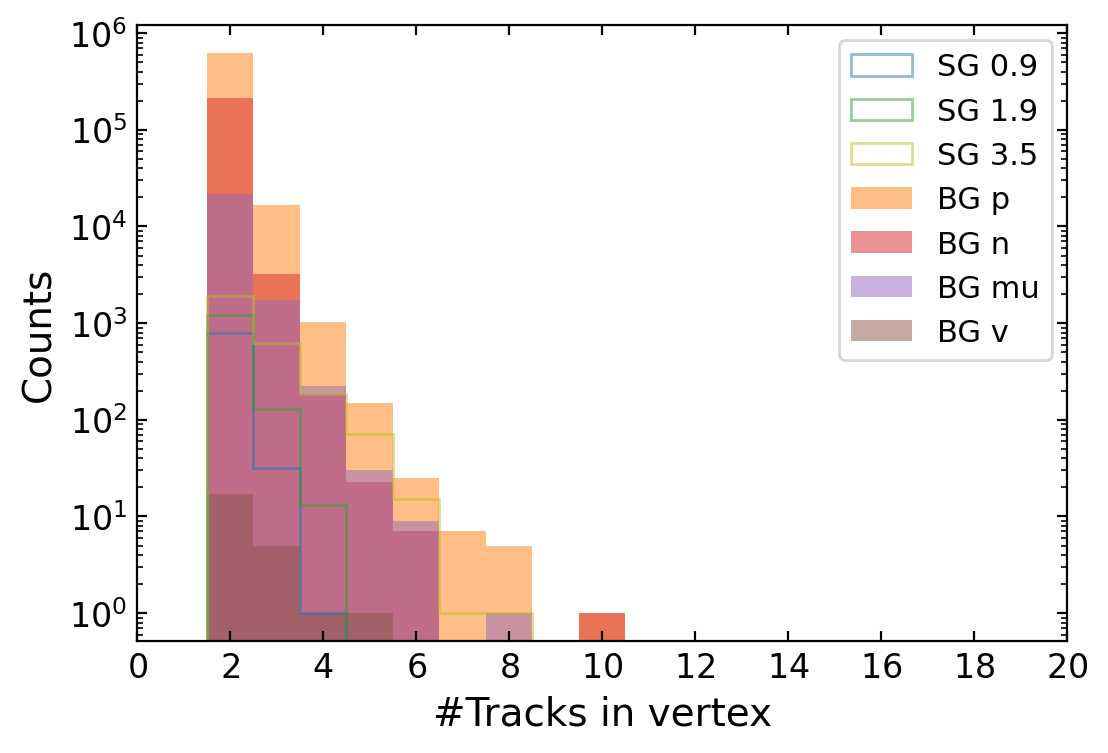

In [113]:
for name, cfg in plot_settings.items():
    res = data[name]
    plt.hist(res["vertex_ntracks"], bins=21,range=(-0.5,20.5), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)


# plt.axvspan(0,NTRACK+0.5,color="r", alpha=0.1, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("#Tracks in vertex")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0,20)
save_fig("comb_ntrack_hits")
plt.show()

In [114]:
# for name, cfg in plot_settings.items():
#     res = data[name]
#     plt.hist(res["vertex_topfrac"][res["vertex_ntracks"]==2], bins=21,range=(0,1), alpha=0.5, 
#              color=cfg.color, label=cfg.label, histtype=cfg.histtype)




# plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
# plt.yscale("log")
# plt.xlabel("#Tracks in vertex")
# plt.ylabel("Counts")
# plt.legend(loc=(1.01,0))
# plt.show()

---

# Cuts

815
0.0 5.0


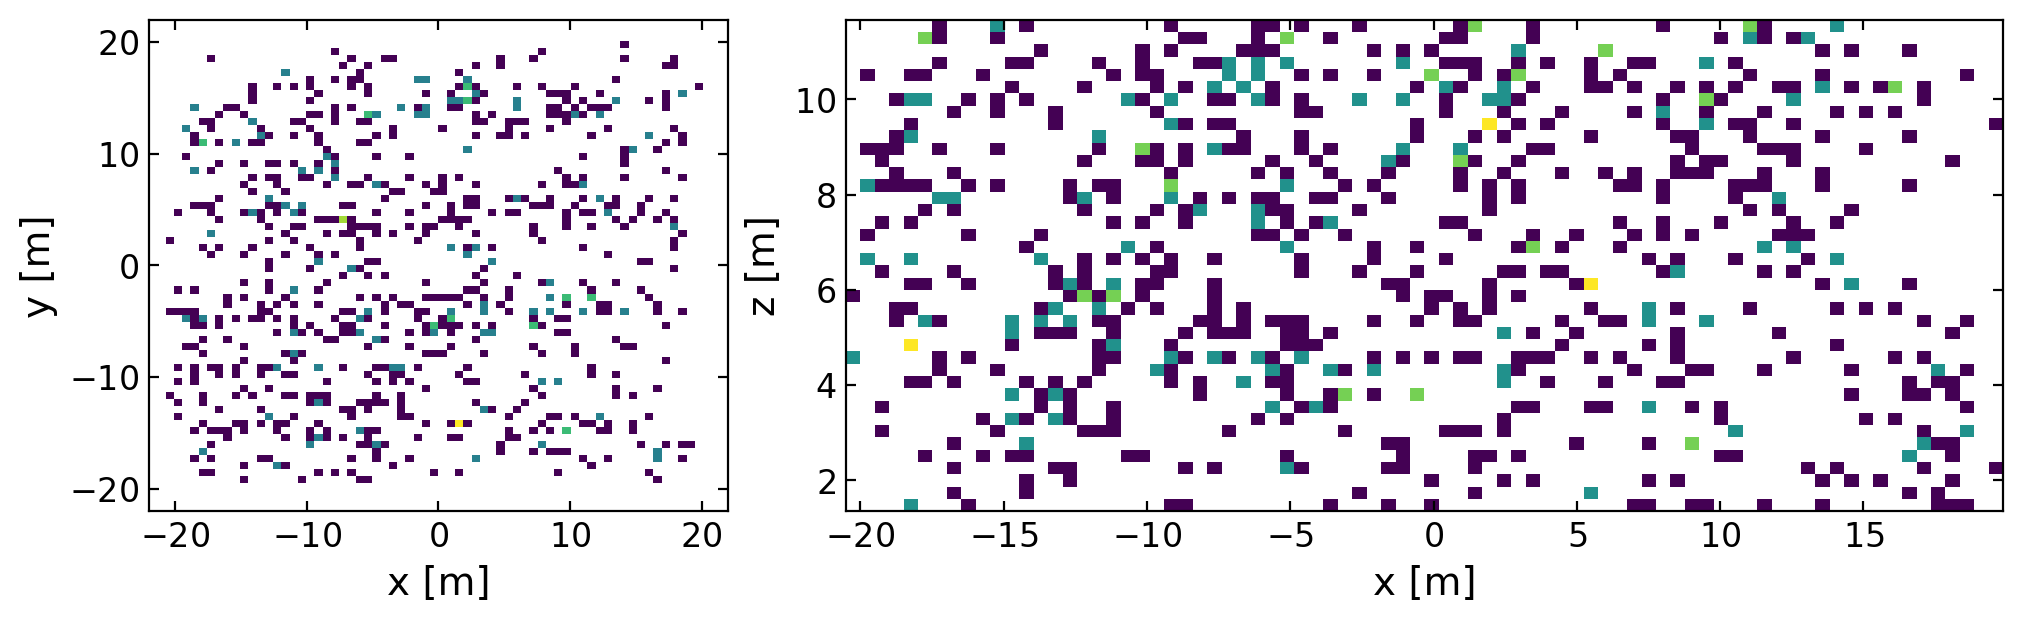

1332
0.0 6.0


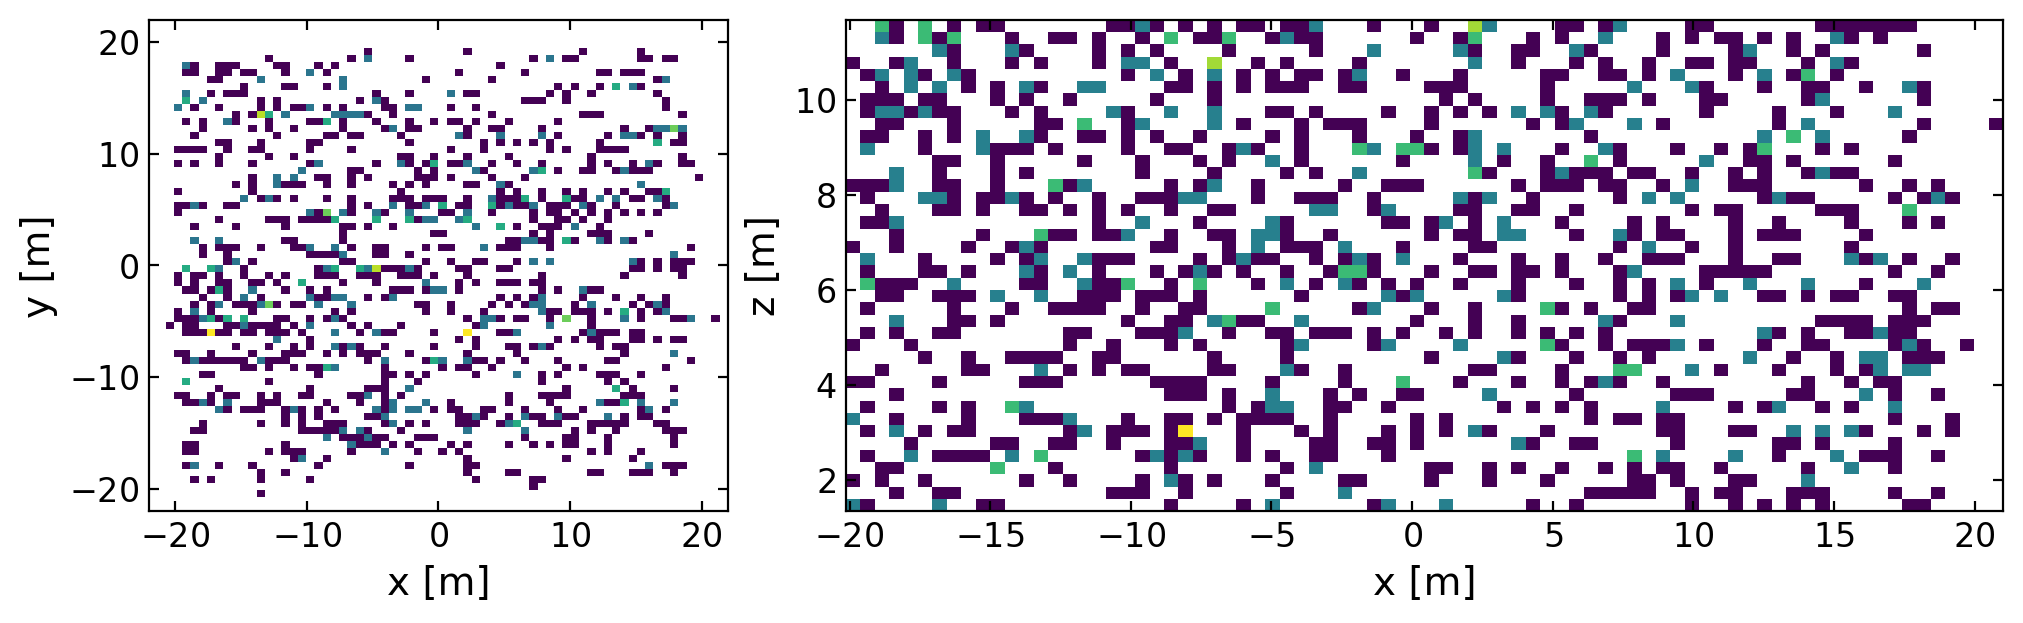

2718
0.0 8.0


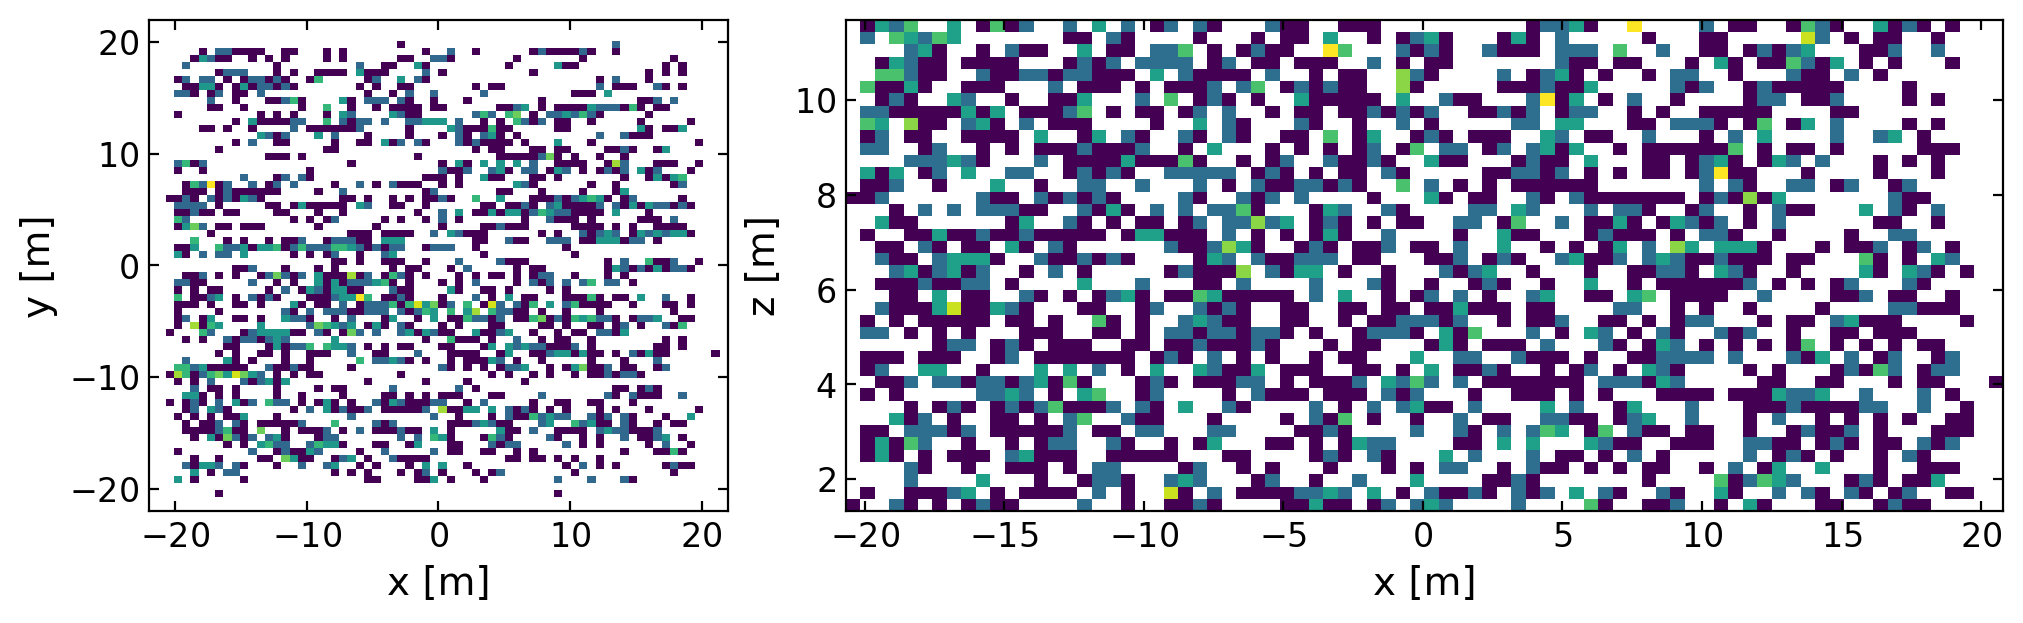

566577
0.0 576.0


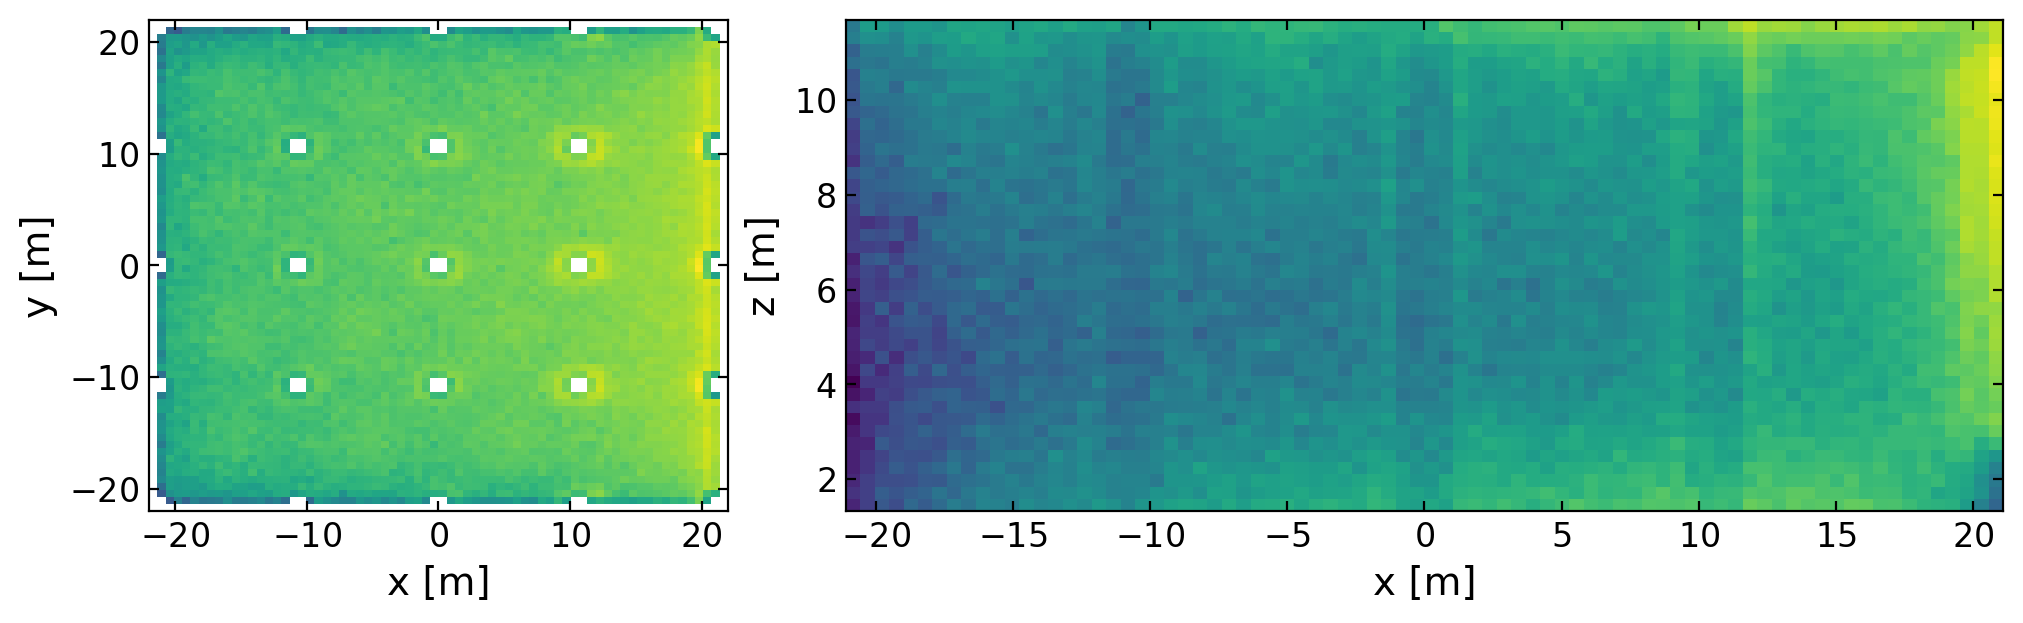

200440
0.0 141.0


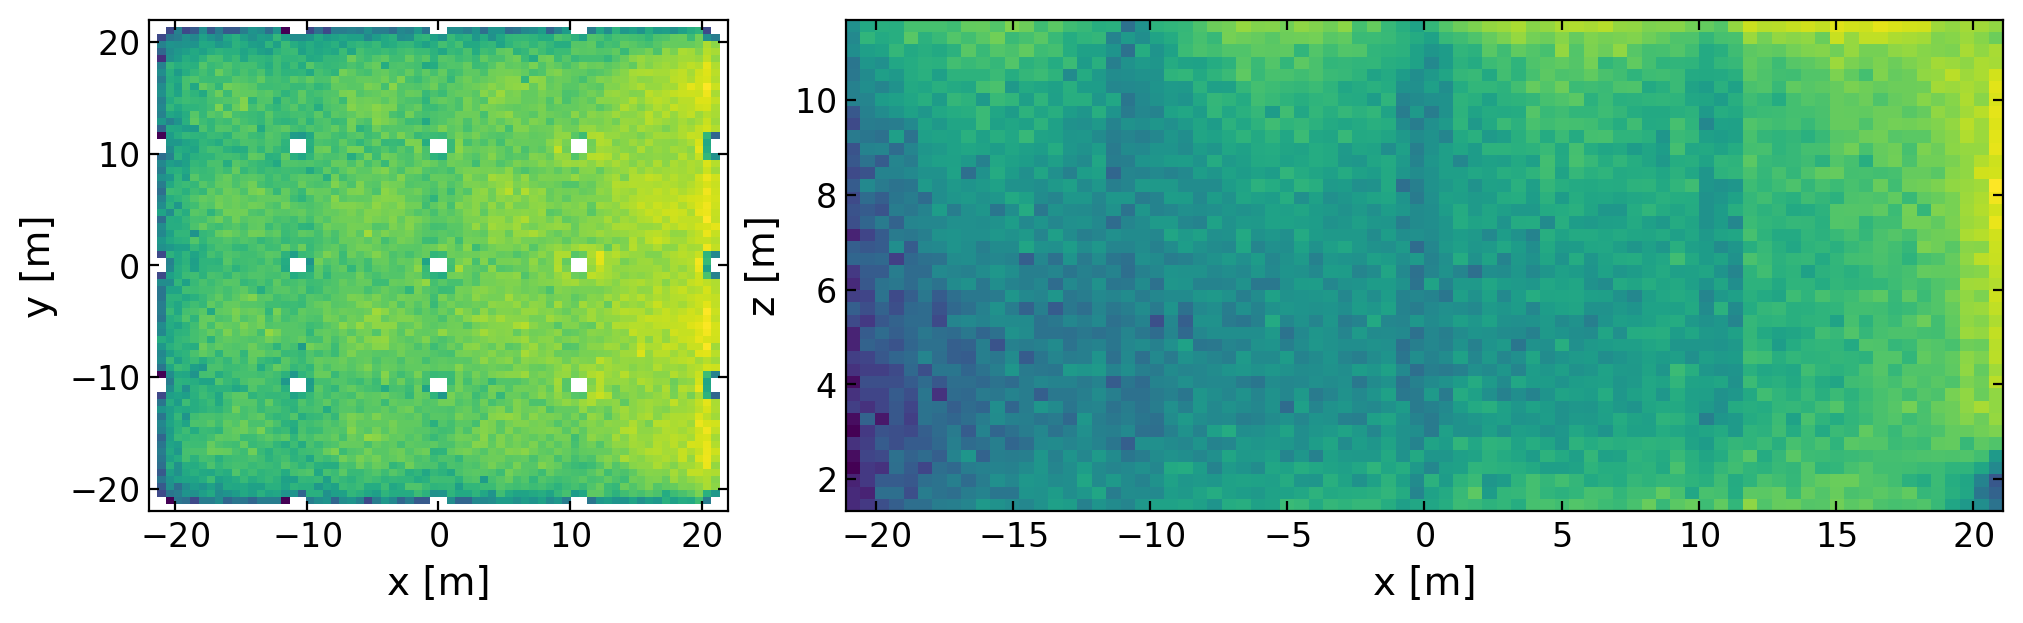

23056
0.0 27.0


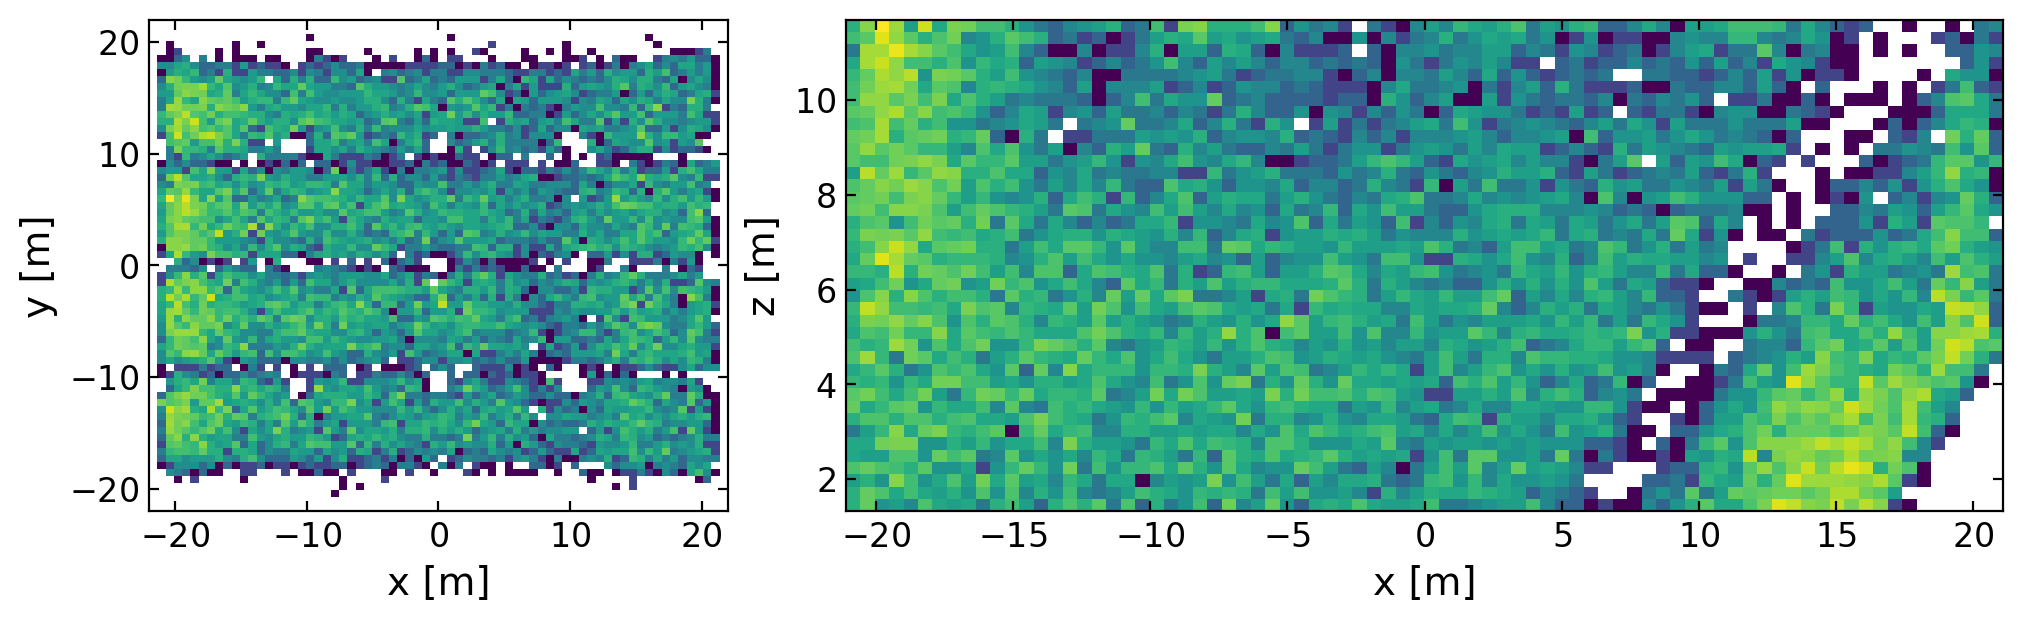

22
0.0 2.0


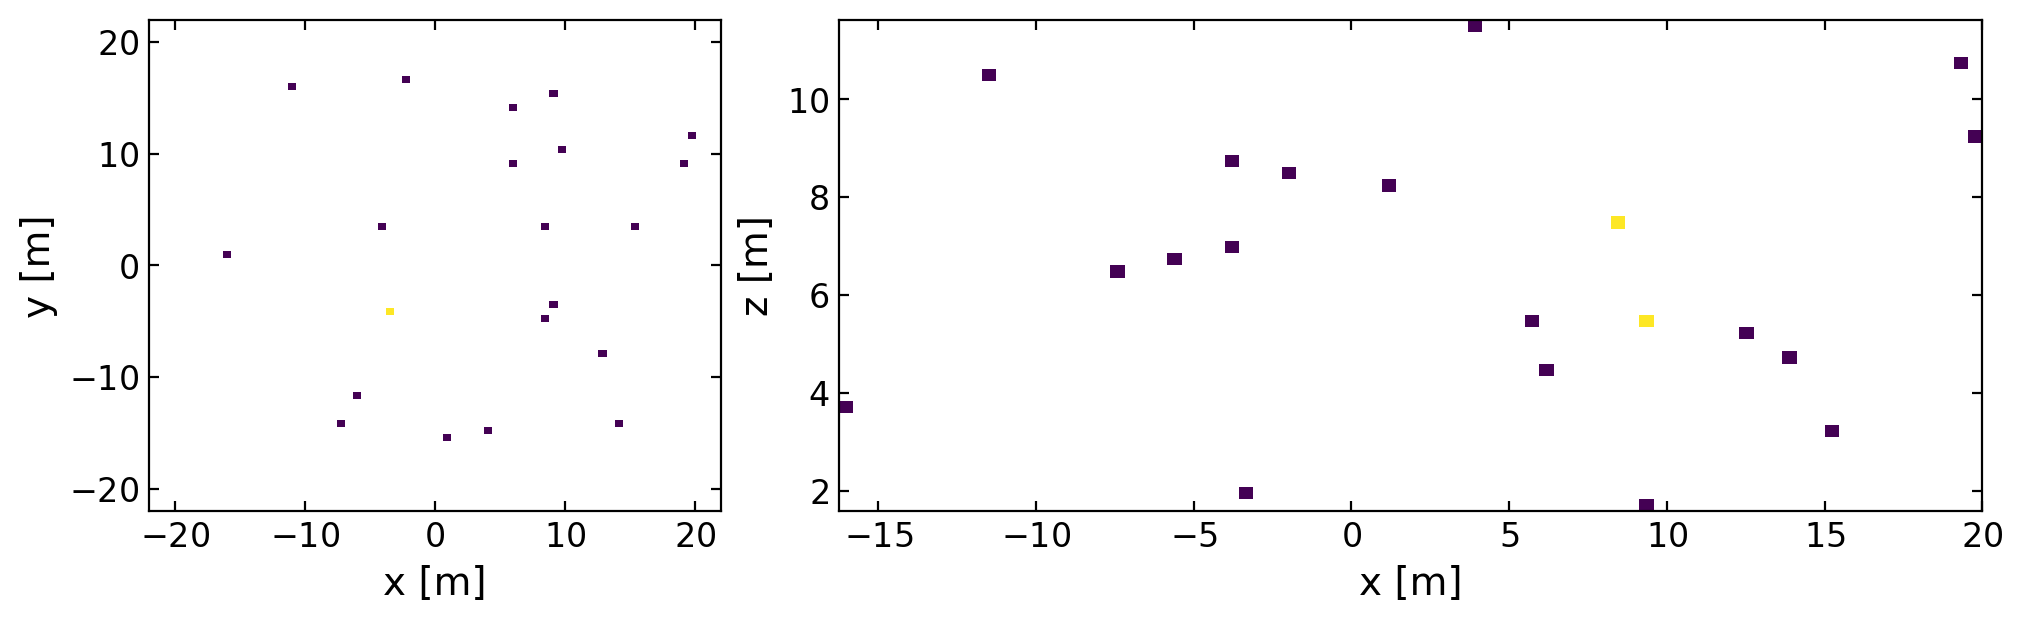

In [115]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask =  res.get_cut("Fiducial volume") # & res.get_cut("N track downward")#| res.get_cut("True") res.get_cut(f"More than 2 tracks") #
    mask_fid = res.get_cut("Fiducial volume")#| res.get_cut("True")
    print(sum(mask_fid))
    
    fig = plt.figure(figsize=(10,3), layout="constrained")
    spec = fig.add_gridspec(1,3)
    
    ax1 = fig.add_subplot(spec[:, :1])
    ax2 = fig.add_subplot(spec[:, 1:])


    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,1])[mask]/1000
    x_reject = (res["vertex_xyzt"][:,0])[mask&mask_fid]/1000
    y_reject = (res["vertex_xyzt"][:,1])[mask&mask_fid] /1000   
    h,xe,ye = hp.histogram2d(x, y, bins=(70,70), range=((-22,22),(-22,22)))
    print(np.min(h), np.max(h))
    ax1.hist2d(x, y, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.hist2d(x_reject, y_reject, bins=(70,70), range=((-22,22),(-22,22)), norm=mpl.colors.LogNorm(vmin = 1, vmax = np.max(h)))
    # ax1.scatter(x_reject, y_reject, alpha=0.83, s=1, color="r")
    # plt.colorbar()
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")

    x = (res["vertex_xyzt"][:,0])[mask]/1000
    y = (res["vertex_xyzt"][:,2])[mask]/1000
    ax2.hist2d(x, y, bins=(80,40), norm=mpl.colors.LogNorm())
    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("z [m]")
    
    plt.show()

In [ ]:
lim_vertex_track_dist = 1
c_vertex_track_dist = lambda res: res["vertex_track_dist"]/1e3/res["vertex_ntracks"] < lim_vertex_track_dist

lim_track_veto_dist = 15
c_track_veto_dist = lambda res: res["vertex_track_to_veto_dist"]/1000 > lim_track_veto_dist

0.8180722891566266
0.8049853372434017
0.7873481057898499
0.6275802792689972
0.7080600069435562
0.869137574401621
0.6666666666666666


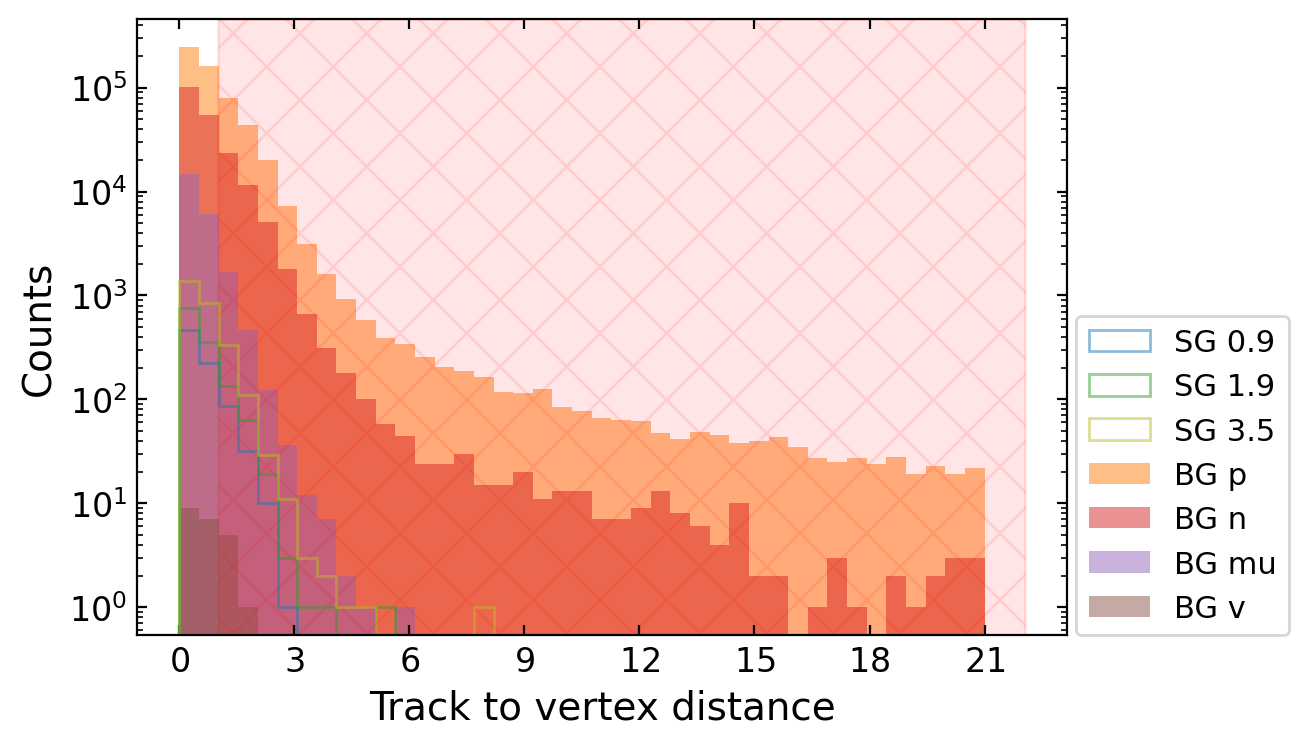

In [276]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask_accu = res.get_cut("Fiducial volume")    
    mask_this = res.get_cut("Track-vertex distance")
    x = res["vertex_track_dist"]/1e3/res["vertex_ntracks"]
    plt.hist(x[mask_accu], bins=41,range=(0,21), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    mask  = mask_accu&mask_this
    print(sum(mask)/len(mask))


plt.axvspan(lim_vertex_track_dist, plt.gca().get_xlim()[1],color="r", alpha=0.1, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("Track-vertex distance")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

sig 0.65 0.7987951807228916
sig 1.90 0.7404692082111437
sig 4.80 0.6515368120085776
bkg p 0.06818747563558825
bkg n 0.17761799477406034
bkg mu 0.00037992317109206803
bkg v 0.16666666666666666


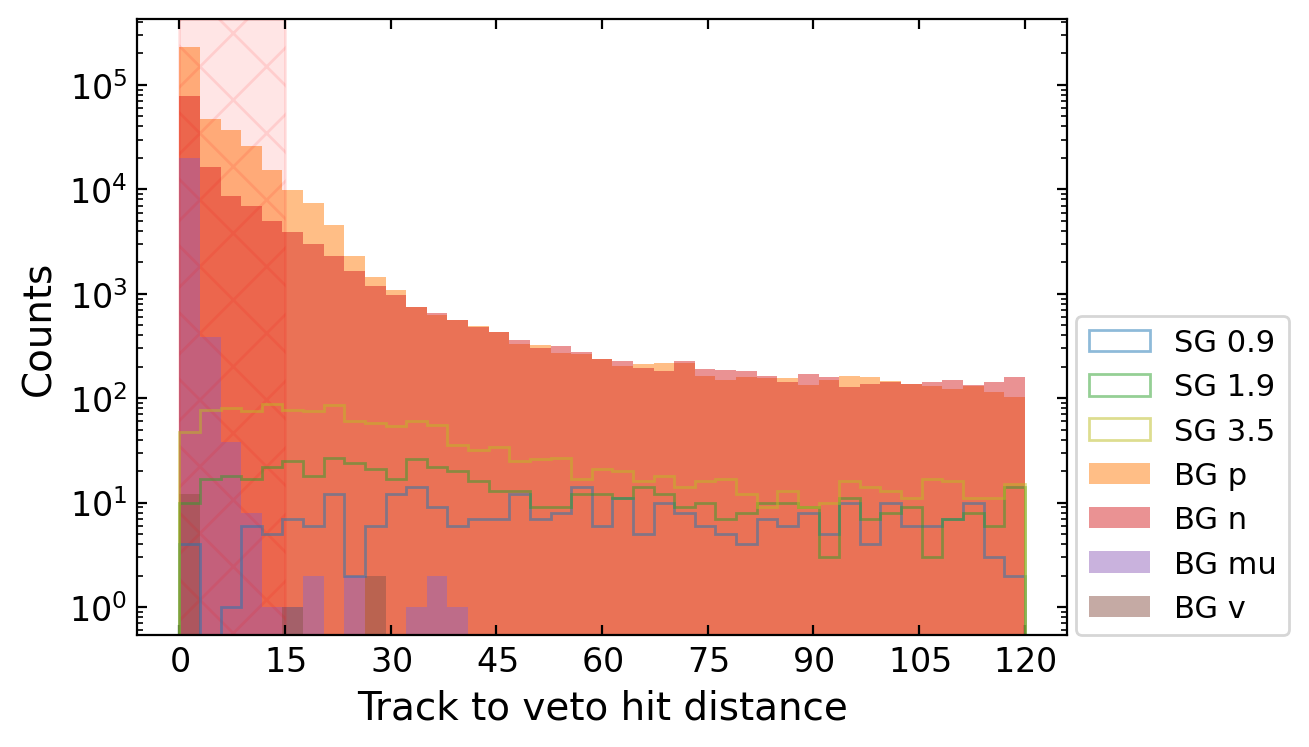

In [280]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance")
    mask_this = res.get_cut("Track-veto distance")
    x = res["vertex_track_to_veto_dist"]/1e3
    plt.hist(x[mask_accu], bins=41,range=(0,120), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask))


plt.axvspan(0, lim_track_veto_dist, color="r", alpha=0.1, hatch="X")

plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("Track to veto hit distance")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

sig 0.65 0.6963855421686747
sig 1.90 0.6781524926686217
sig 4.80 0.5868477483917084
bkg p 0.04404929086841417
bkg n 0.12670162808120305
bkg mu 0.00012664105703068934
bkg v 0.125


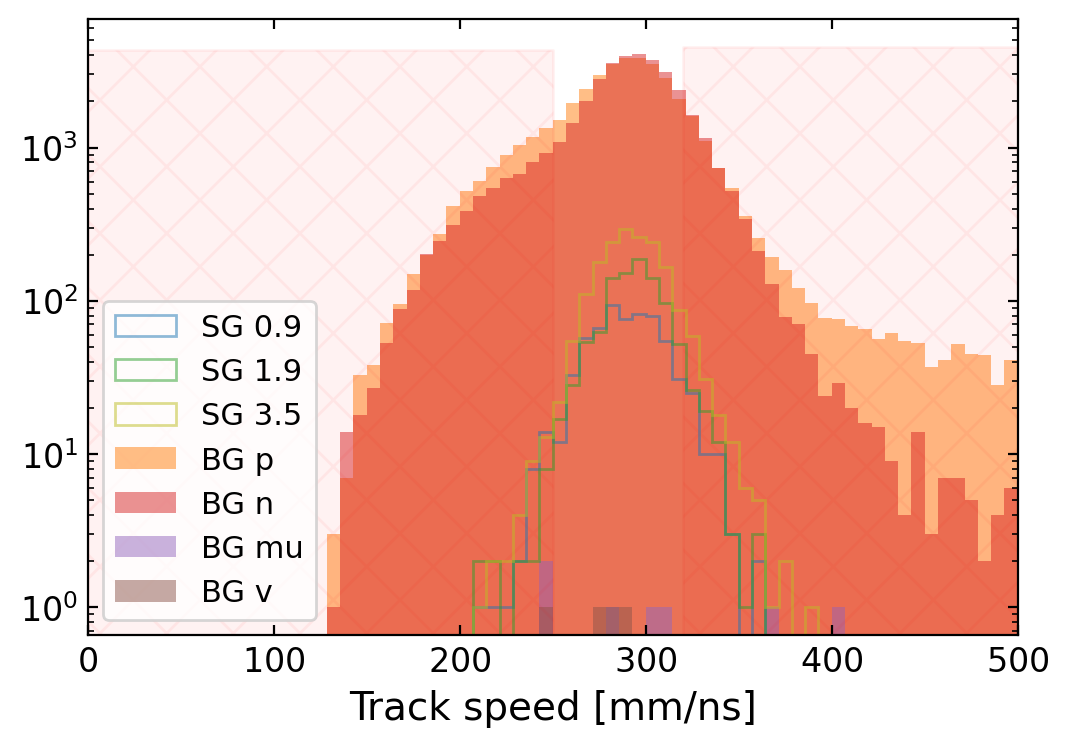

In [282]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance")
    mask_this = res.get_cut("Track velocity")
    plt.hist(res["vertex_slowest_track"][mask_accu], bins=70,range=(0,500),alpha=0.5, color=cfg.color, label=cfg.label, histtype=cfg.histtype)
    
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask))
    
plt.xlabel("Track speed [mm/ns]")
# plt.ylim(1,2e3)
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 250, color="r", alpha=0.05, hatch="X")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 320, 500, color="r", alpha=0.05, hatch="X")

plt.xlim(0,500)
plt.yscale("log")
plt.legend()
save_fig("comb_track_speed")
plt.show()

sig 0.65 0.6759036144578313
sig 1.90 0.655425219941349
sig 4.80 0.5668334524660472
bkg p 0.01640889314727925
bkg n 0.09614541268478081
bkg mu 4.221368567689645e-05
bkg v 0.0


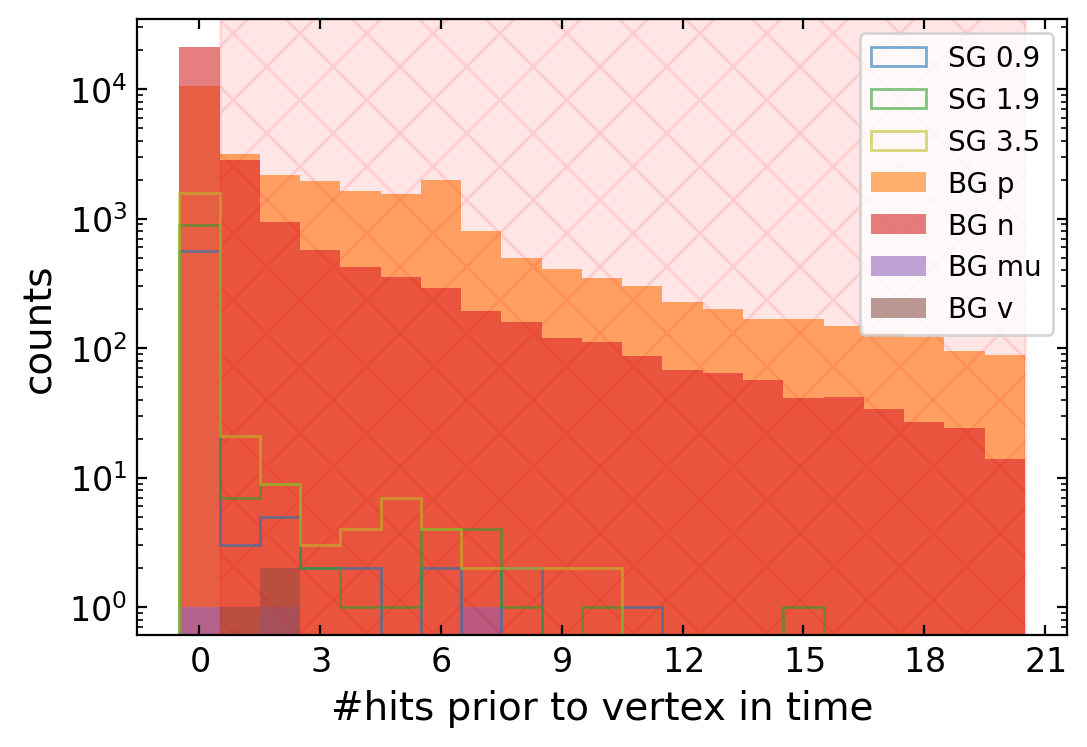

In [285]:
for name, cfg in plot_settings.items():
    res = data[name]

    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")    
    mask_this = res.get_cut("N digi before")
    plt.hist(res["vertex_ndigi_before_limited"][mask_accu], range=(-0.5,20.5), bins=21, alpha=0.6,\
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask))    

plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))

plt.xlabel("#hits prior to vertex in time")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()
plt.axvspan(0.5,20.5,color="r", alpha=0.1, hatch="X")

lh = plt.legend(fontsize=10)
save_fig("comb_nhits_prior")


sig 0.65 0.6397590361445783 531
sig 1.90 0.5791788856304986 790
sig 4.80 0.4867762687634024 1362
bkg p 0.012220954098622443 7806
bkg n 0.08363787527180368 18309
bkg mu 4.221368567689645e-05 1
bkg v 0.0 0


/tmp/ipykernel_1097/3547286424.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_1097/3547286424.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lh = plt.legend(fontsize=10)


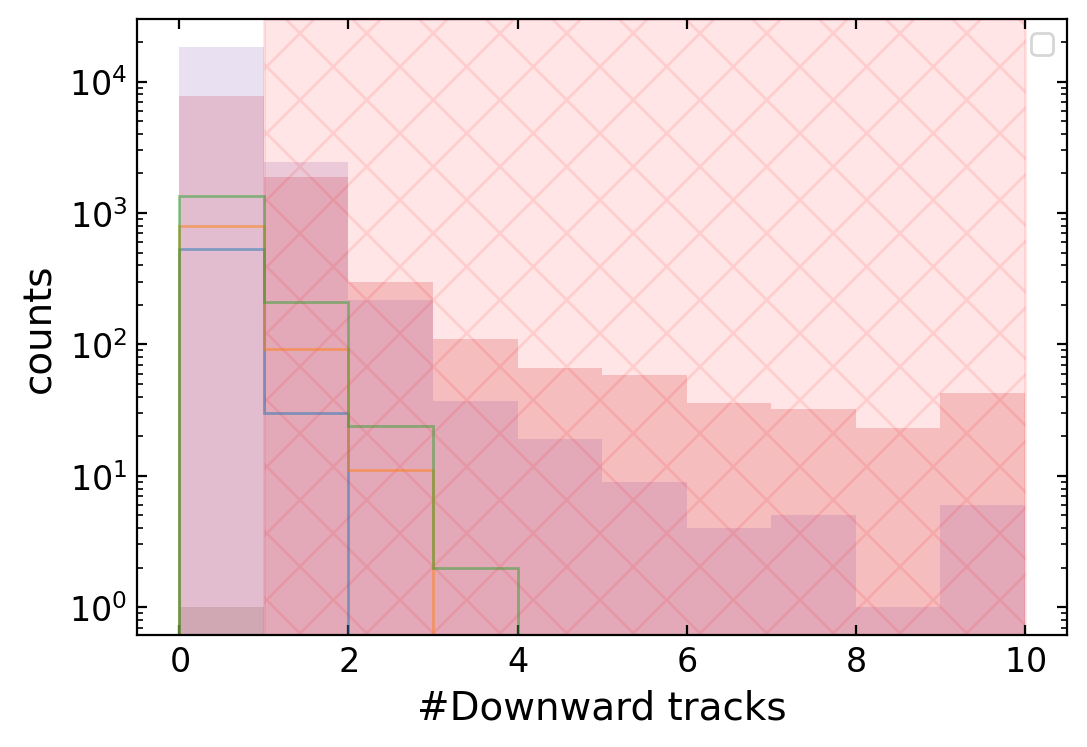

In [322]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before")  
    mask_this = res.get_cut("N track downward") 
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask), sum(mask))       
    
    x = (res["event_ndownward_track"][:,0] + res["event_ndownward_track"][:,1])
    plt.hist(x[mask_accu], bins=np.linspace(0,10,11), histtype=cfg.histtype, log=1, alpha=cfg.alpha_marker)

plt.xlabel("#Downward tracks")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()
plt.axvspan(1,10,color="r", alpha=0.1, hatch="X")

lh = plt.legend(fontsize=10)

sig 0.65 0.6397590361445783 531
sig 1.90 0.5703812316715543 778
sig 4.80 0.45997140814867765 1287
bkg p 0.009254171109013228 5911
bkg n 0.07674000036545033 16799
bkg mu 4.221368567689645e-05 1
bkg v 0.0 0


Text(0.5, 0, '#veto hits')

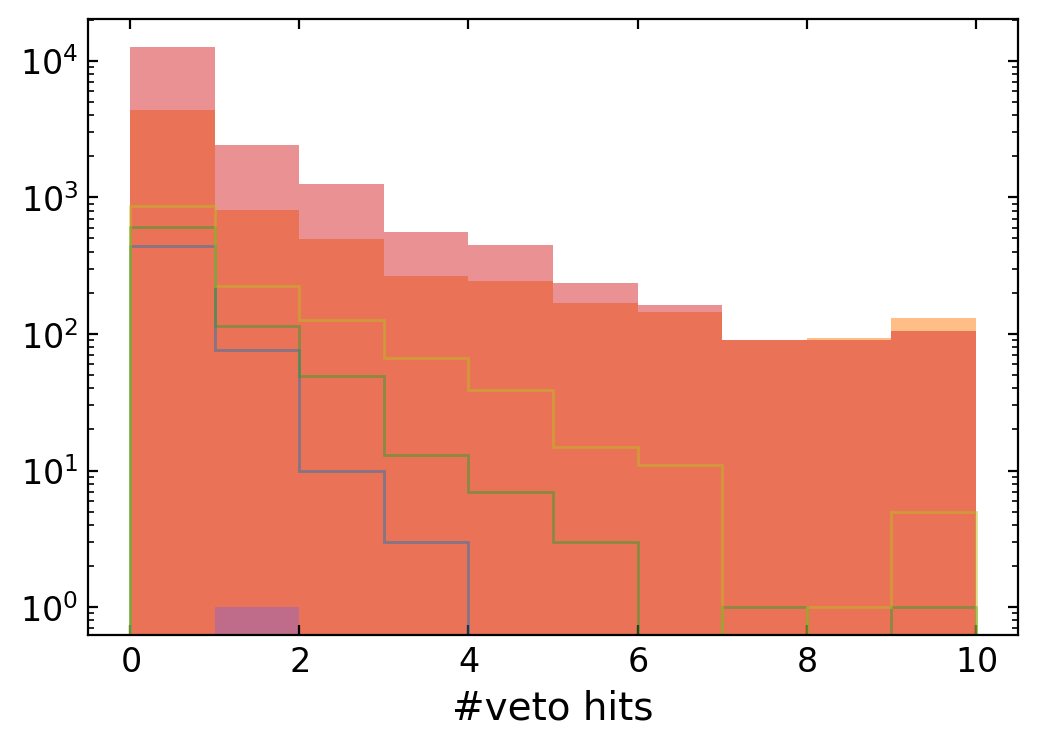

In [350]:

for name, cfg in plot_settings.items():
#     # if "bkg" in name:
#     #     continue
    
    res = data[name]

    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before") & res.get_cut("N track downward") 
    mask_this = res.get_cut("N_veto")
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask), sum(mask))   
    
    x = ( res["vertex_ndigi_veto_after"])
    # plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize*4)
    plt.hist(x[mask_accu], bins=10, range=(0,10), alpha=0.5, 
         color=cfg.color, label=cfg.label, histtype=cfg.histtype)


plt.yscale("log")
plt.xlabel("#veto hits")

sig 0.65 0.25301204819277107 210
sig 1.90 0.15469208211143695 211
sig 4.80 0.18406004288777697 515
bkg p 4.8533125423686354e-05 31
bkg n 0.0007034918778665009 154
bkg mu 0.0 0
bkg v 0.0 0


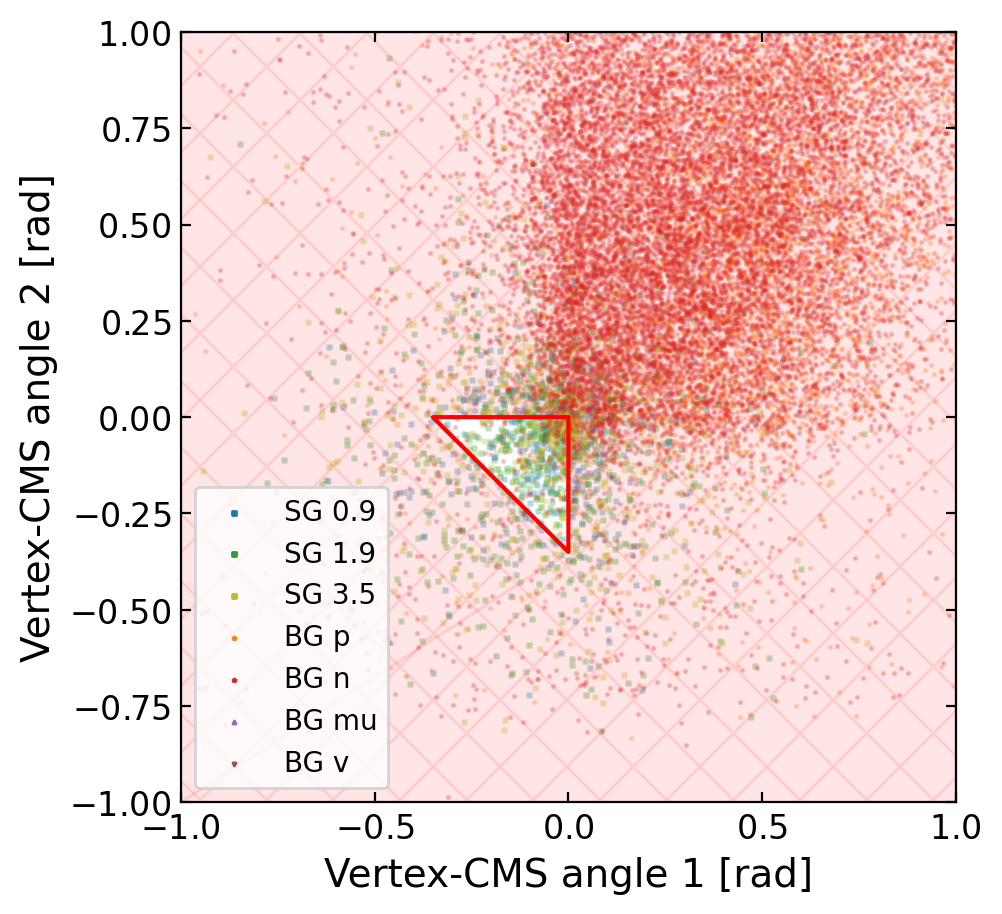

In [349]:
plt.figure(figsize=(5,5))
for name, cfg in plot_settings.items():
    res = data[name]

    # if "bkg" in name: 
    #     continue

    c2 = res.get_cut("More than 2 tracks")
    mask_accu =  res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before") & res.get_cut("N track downward") & res.get_cut("N_veto")
    mask_this =  res.get_cut("Angle to CMS")
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask), sum(mask))  

    
    x = (res["vertex_cms_angle_h"])[mask_accu & (~c2)]
    y = res["vertex_cms_angle_v"][mask_accu & (~c2)]
    alpha = cfg.alpha_marker*0.4 if "sig" in name else cfg.alpha_marker
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize*0.3)

# Plot the cut region
# poly = [[-cut_angel_v1,0], [0, cut_angel_v1], [cut_angel_v1,0], [0, -cut_angel_v1], [0,-cut_angel_v2], [-cut_angel_v2,0]]
poly = [[0,0], [0,-cut_angel_v2], [-cut_angel_v2,0]]
polt_out = np.transpose(hplt.fill_outside(np.transpose(poly)[0],np.transpose(poly)[1], [-1,-1],[1,1]))

col1 = mpl.collections.PolyCollection([poly], edgecolors="r")
col1.set_linewidth(1.5)
col1.set_facecolor("none")  # Transparent face
col = mpl.collections.PolyCollection([polt_out], edgecolors="r", alpha=0.1, hatch="X")
col.set_facecolor('r')  # Transparent face
plt.gca().add_collection(col1)
plt.gca().add_collection(col)




plt.xlabel("Vertex-CMS angle 1 [rad]")
plt.ylabel("Vertex-CMS angle 2 [rad]")
# plt.yscale("log")
plt.xlim(-1,1)
plt.ylim(-1,1)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque

save_fig("comb_cms_angle")

sig 0.65 0.1746987951807229 145
sig 1.90 0.1063049853372434 145
sig 4.80 0.09185132237312366 257
bkg p 2.6614939748473164e-05 17
bkg n 0.0003197690353938641 70
bkg mu 0.0 0
bkg v 0.0 0


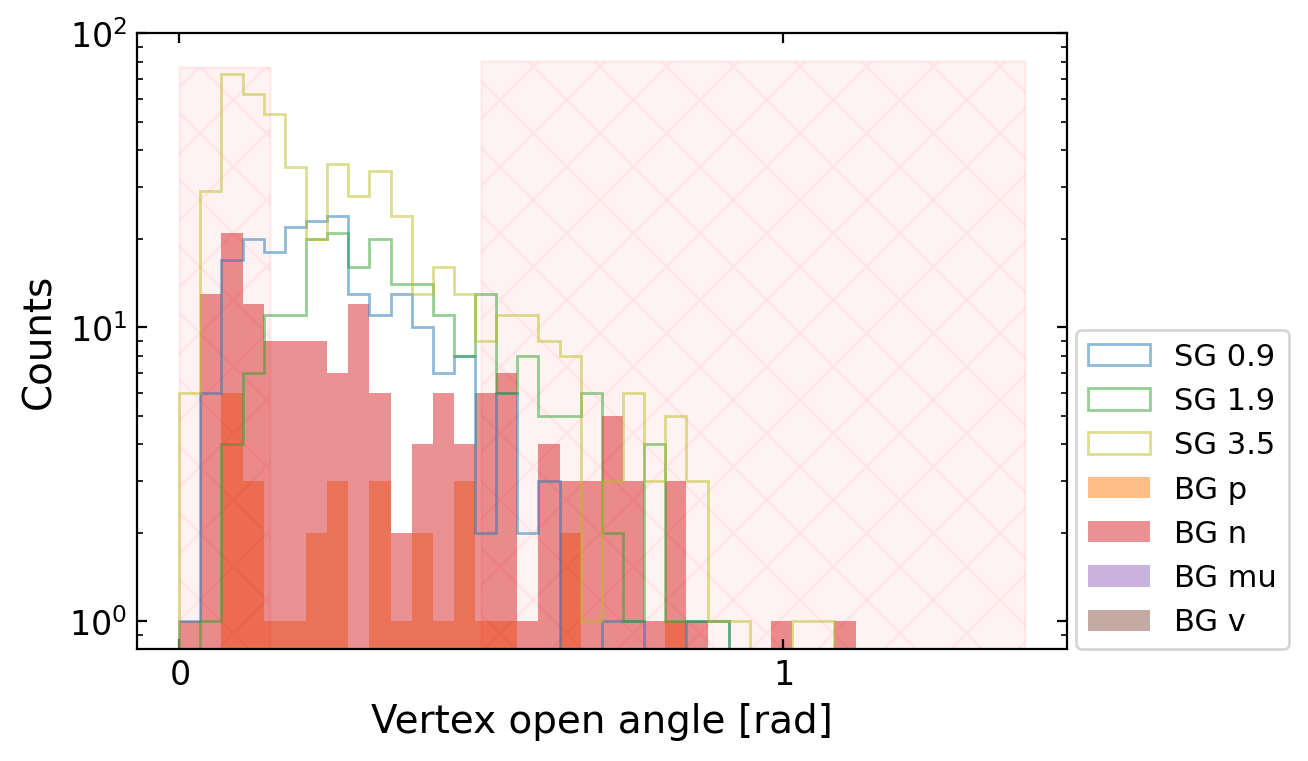

In [329]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before") & res.get_cut("N track downward")  & res.get_cut("N_veto") & res.get_cut("Angle to CMS")
    mask_this = res.get_cut("Open angle")
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask), sum(mask))  
    
    plt.hist((res["vertex_open_angle"])[mask_accu], bins=40,range=(0,1.4), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)
    


plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0, 0.15, color="r", alpha=0.05, hatch="X")
plt.fill_betweenx(np.linspace(*plt.gca().get_ylim()), 0.5,1.4, color="r", alpha=0.05, hatch="X")


plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("Vertex open angle [rad]")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

In [21]:
# plt.figure(figsize=(5,5))
# for name, cfg in plot_settings.items():
#     res = data[name]

#     # if "bkg" in name:
#     #     continue
    
#     c2 = res.get_cut("More than 2 tracks")
#     mask =  (~c2) & res.get_cut("N track downward") & res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") #& res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2") # &res.get_cut("N_tracks")  | res.get_cut("True")
    
#     x = (res["vertex_cms_angle_v_span"])[mask]
#     y = res["vertex_cms_angle_v"][mask]
#     alpha = cfg.alpha_marker*0.4 if "sig" in name else cfg.alpha_marker
#     plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize*0.3)
    






# plt.xlabel("Vertex-CMS angle 1 span [rad]")
# plt.ylabel("Vertex-CMS angle 1 dev [rad]")
# # plt.yscale("log")
# plt.xlim(-1,1)
# plt.ylim(-1,1)

# lh = plt.legend(fontsize=10)
# # make legend non-transparent
# for handle in lh.legend_handles:
#     handle.set_alpha(1.0)  # Make legend items fully opaque

sig 0.65 0.16626506024096385 138
sig 1.90 0.10190615835777127 139
sig 4.80 0.08899213724088635 249
bkg p 1.878701629303988e-05 12
bkg n 0.0002695196155462569 59
bkg mu 0.0 0
bkg v 0.0 0


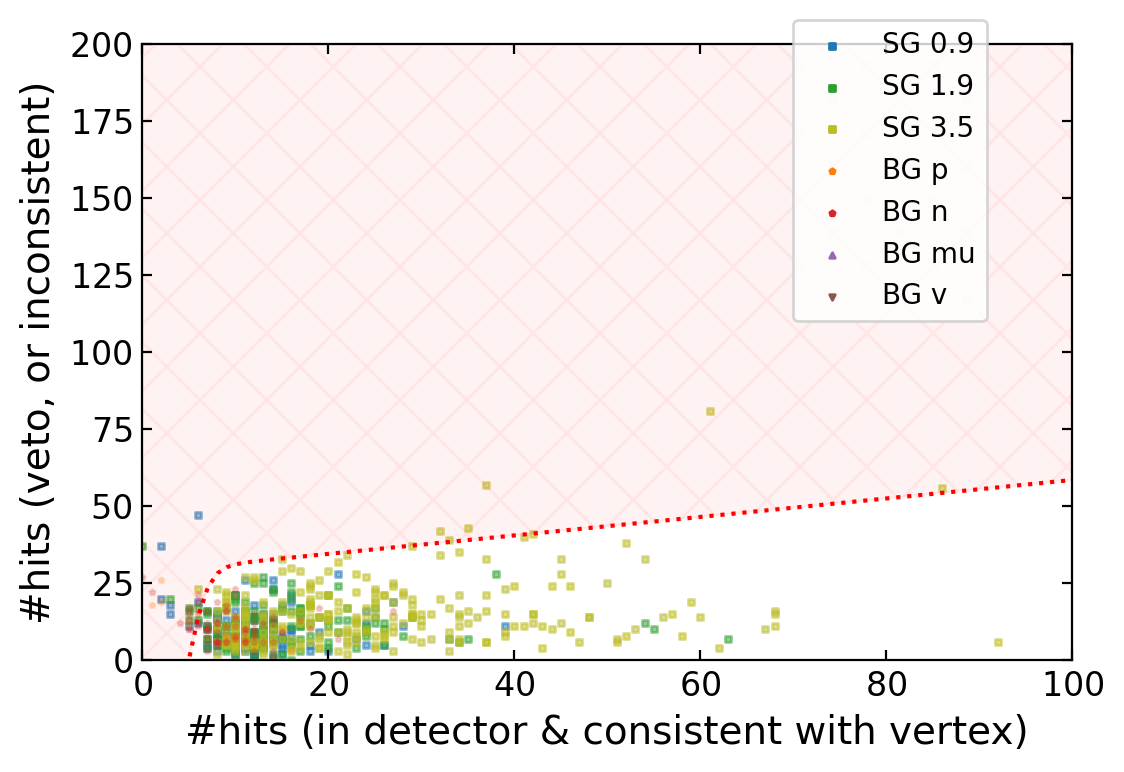

In [330]:
def f_nhits_cut(x):
    x0 = 5
    squeeze = 2
    yscale = 30
    slope = 0.3
    y =  np.tanh((x-x0)/squeeze ) * yscale * (1+ (x-x0)/yscale * slope)
    return y

for name, cfg in plot_settings.items():
    res = data[name]

    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before") & res.get_cut("N track downward") & res.get_cut("N_veto") & res.get_cut("Angle to CMS") & res.get_cut("Open angle")
    mask_this = res.get_cut("N_hits vs N_veto")
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask), sum(mask))   

    
    x = (res["vertex_ndigi_active_after_comp"])[mask_accu]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[mask_accu]
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=cfg.alpha_marker, s=cfg.markersize)


xlim = 100
ylim = 200
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut(x_plot), ylim, color="r", alpha=0.05, hatch="X")
plt.xlabel("#hits (in detector & consistent with vertex)")
plt.ylabel("#hits (veto, or inconsistent)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10, loc=(0.7,0.55))
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque


save_fig("comb_n_veto_cut_1")

sig 0.65 0.12891566265060242 107
sig 1.90 0.08504398826979472 116
sig 4.80 0.08327376697641173 233
bkg p 4.69675407325997e-06 3
bkg n 2.740877446233121e-05 6
bkg mu 0.0 0
bkg v 0.0 0


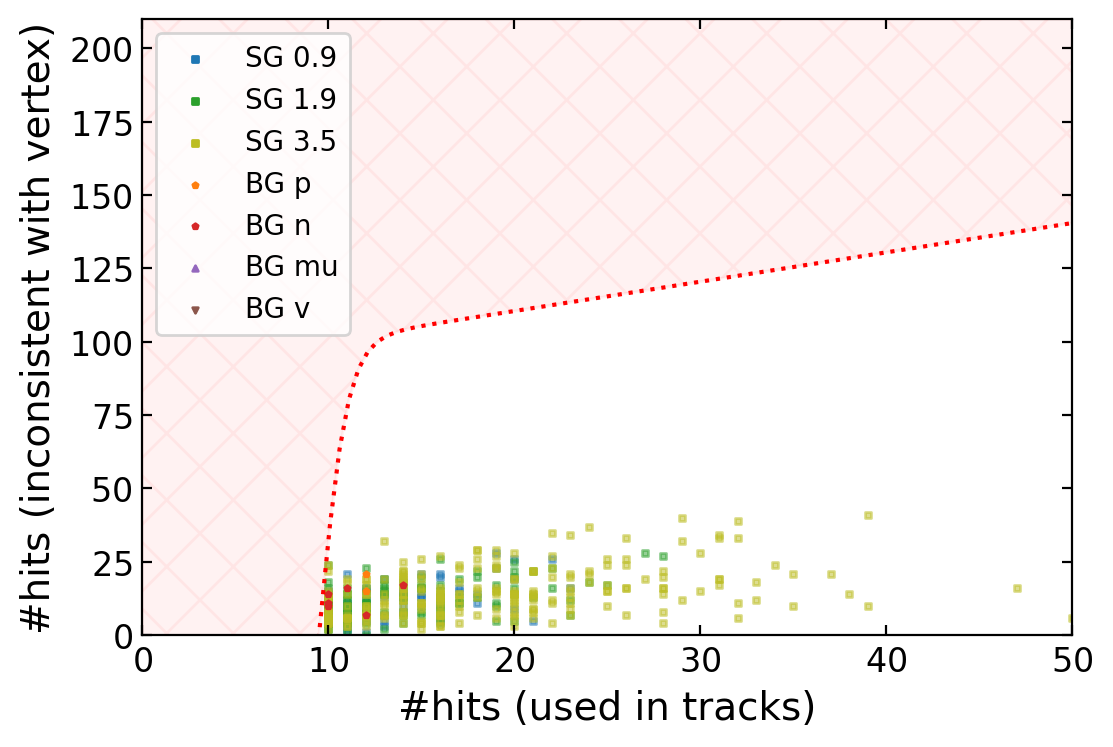

In [337]:
for name, cfg in plot_settings.items():
    res = data[name]
    
    mask_accu = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & res.get_cut("N digi before") & res.get_cut("N track downward")  & res.get_cut("N_veto") & res.get_cut("Angle to CMS") & res.get_cut("Open angle") &\
                res.get_cut("N_hits vs N_veto")
    mask_this = res.get_cut("N_hits vs N_veto 2")
    mask  = mask_accu&mask_this
    print(name, sum(mask)/len(mask), sum(mask))   
    
    x = (res["event_track_nhits"])[mask]
    y = (res["event_nhits"]- res["vertex_ndigi_active_after_comp"])[mask]
    alpha = cfg.alpha_marker if "sig" in name else 1
    plt.scatter(x, y, color=cfg.color, label=cfg.label, marker=cfg.marker, alpha=alpha, s=cfg.markersize)

xlim=50
ylim=210
x_plot = np.linspace(0,xlim,100)
plt.plot(x_plot, f_nhits_cut2(x_plot), color="r", linestyle=":")
plt.fill_between(x_plot, f_nhits_cut2(x_plot), ylim, color="r", alpha=0.05, hatch="X")

plt.xlabel("#hits (used in tracks)")
plt.ylabel("#hits (inconsistent with vertex)")
plt.xlim(0,xlim)
plt.ylim(0,ylim)

lh = plt.legend(fontsize=10)
# make legend non-transparent
for handle in lh.legend_handles:
    handle.set_alpha(1.0)  # Make legend items fully opaque
    
save_fig("comb_n_veto_cut_2")

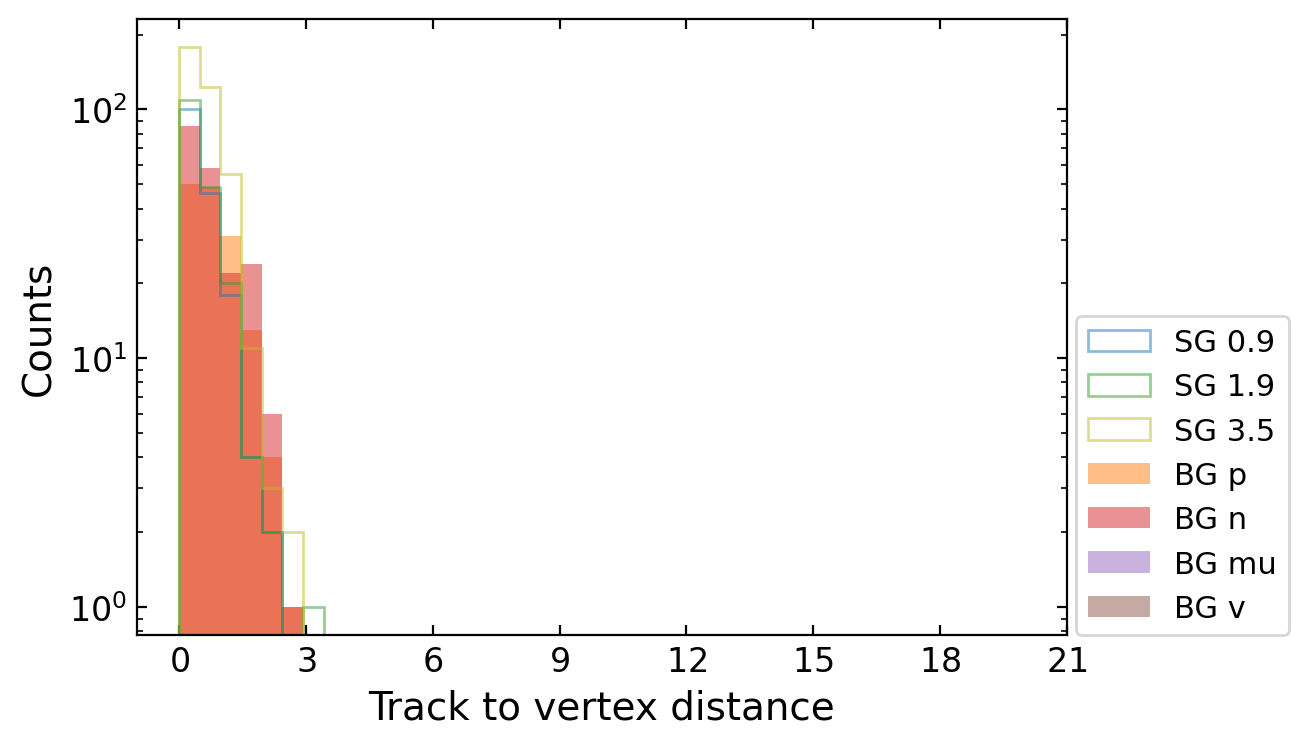

In [240]:
for name, cfg in plot_settings.items():
    res = data[name]
    # plt.hist(res["vertex_track_dist"]/1e3/res["vertex_ntracks"], bins=41,range=(0,20), alpha=0.5, 
    #          color=cfg.color, label=cfg.label, histtype=cfg.histtype)
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") &res.get_cut("Open angle") & res.get_cut("N track downward") #&res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2")
    x = res["vertex_track_dist"]/1e3/res["vertex_ntracks"]
    plt.hist(x[mask], bins=41,range=(0,20), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)


z
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("Track-vertex distance")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

95
132
196
3745
5158
0
1


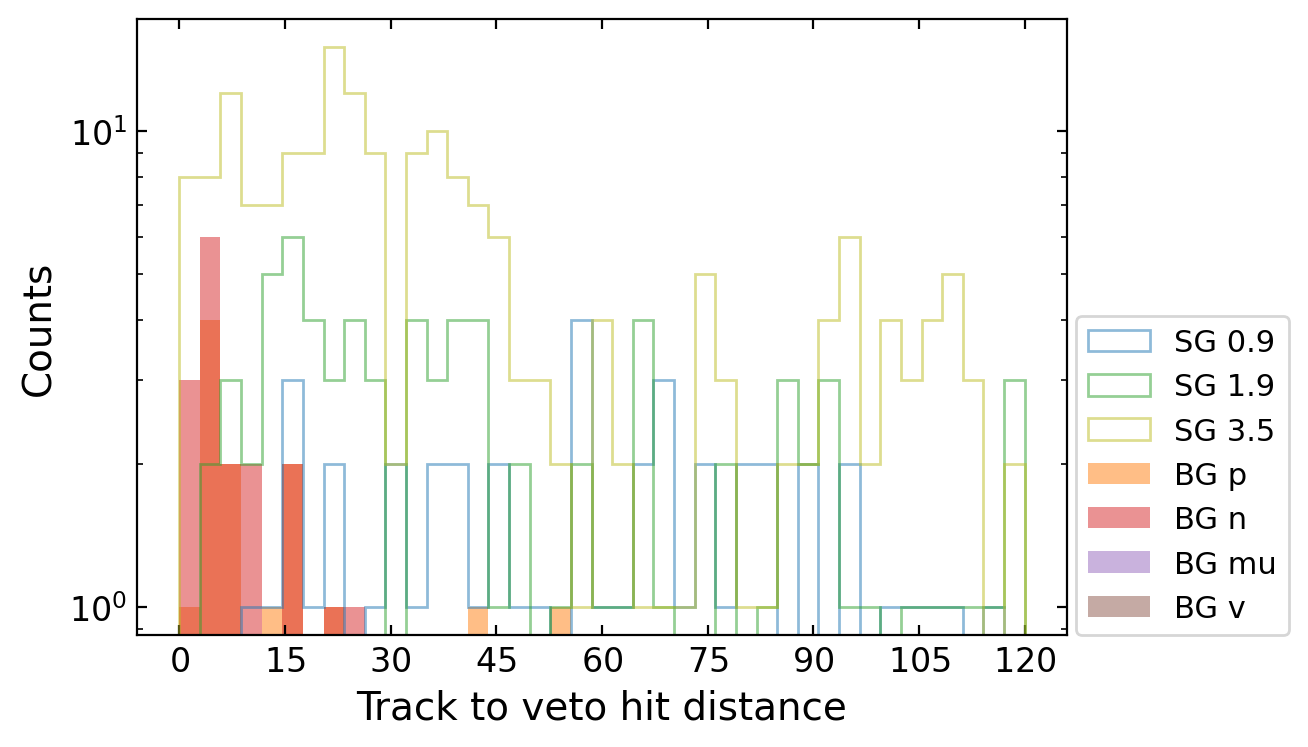

In [257]:
for name, cfg in plot_settings.items():
    res = data[name]
    mask = res.get_cut("Fiducial volume")  & res.get_cut("Track velocity") & res.get_cut("N digi before") & res.get_cut("Angle to CMS") &res.get_cut("Open angle") & res.get_cut("N track downward") &res.get_cut("N_hits vs N_veto") &res.get_cut("N_hits vs N_veto 2")

    plt.hist(res["vertex_track_to_veto_dist"][mask]/1000, bins=41,range=(0,120), alpha=0.5, 
             color=cfg.color, label=cfg.label, histtype=cfg.histtype)

    print(sum(res["vertex_track_to_veto_dist"]==np.inf))



plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, integer=True))
plt.yscale("log")
plt.xlabel("Track to veto hit distance")
plt.ylabel("Counts")
plt.legend(loc=(1.01,0))
plt.show()

---
Plot event

In [675]:
i=3
fname_recon_sig  =   f"{data_dir}/llp_sms/run_{i}_digi_cosmic_recon_skim.root"
fsig1 = root.tfile_reader(fname_recon_sig)
fsig1.get_tree("metadata_digi")
metadata_digi = fsig1.get_entry(0)
fsig1.get_tree("data;1")
print(f"Entries", fsig1.entries)

Entries 1445


116


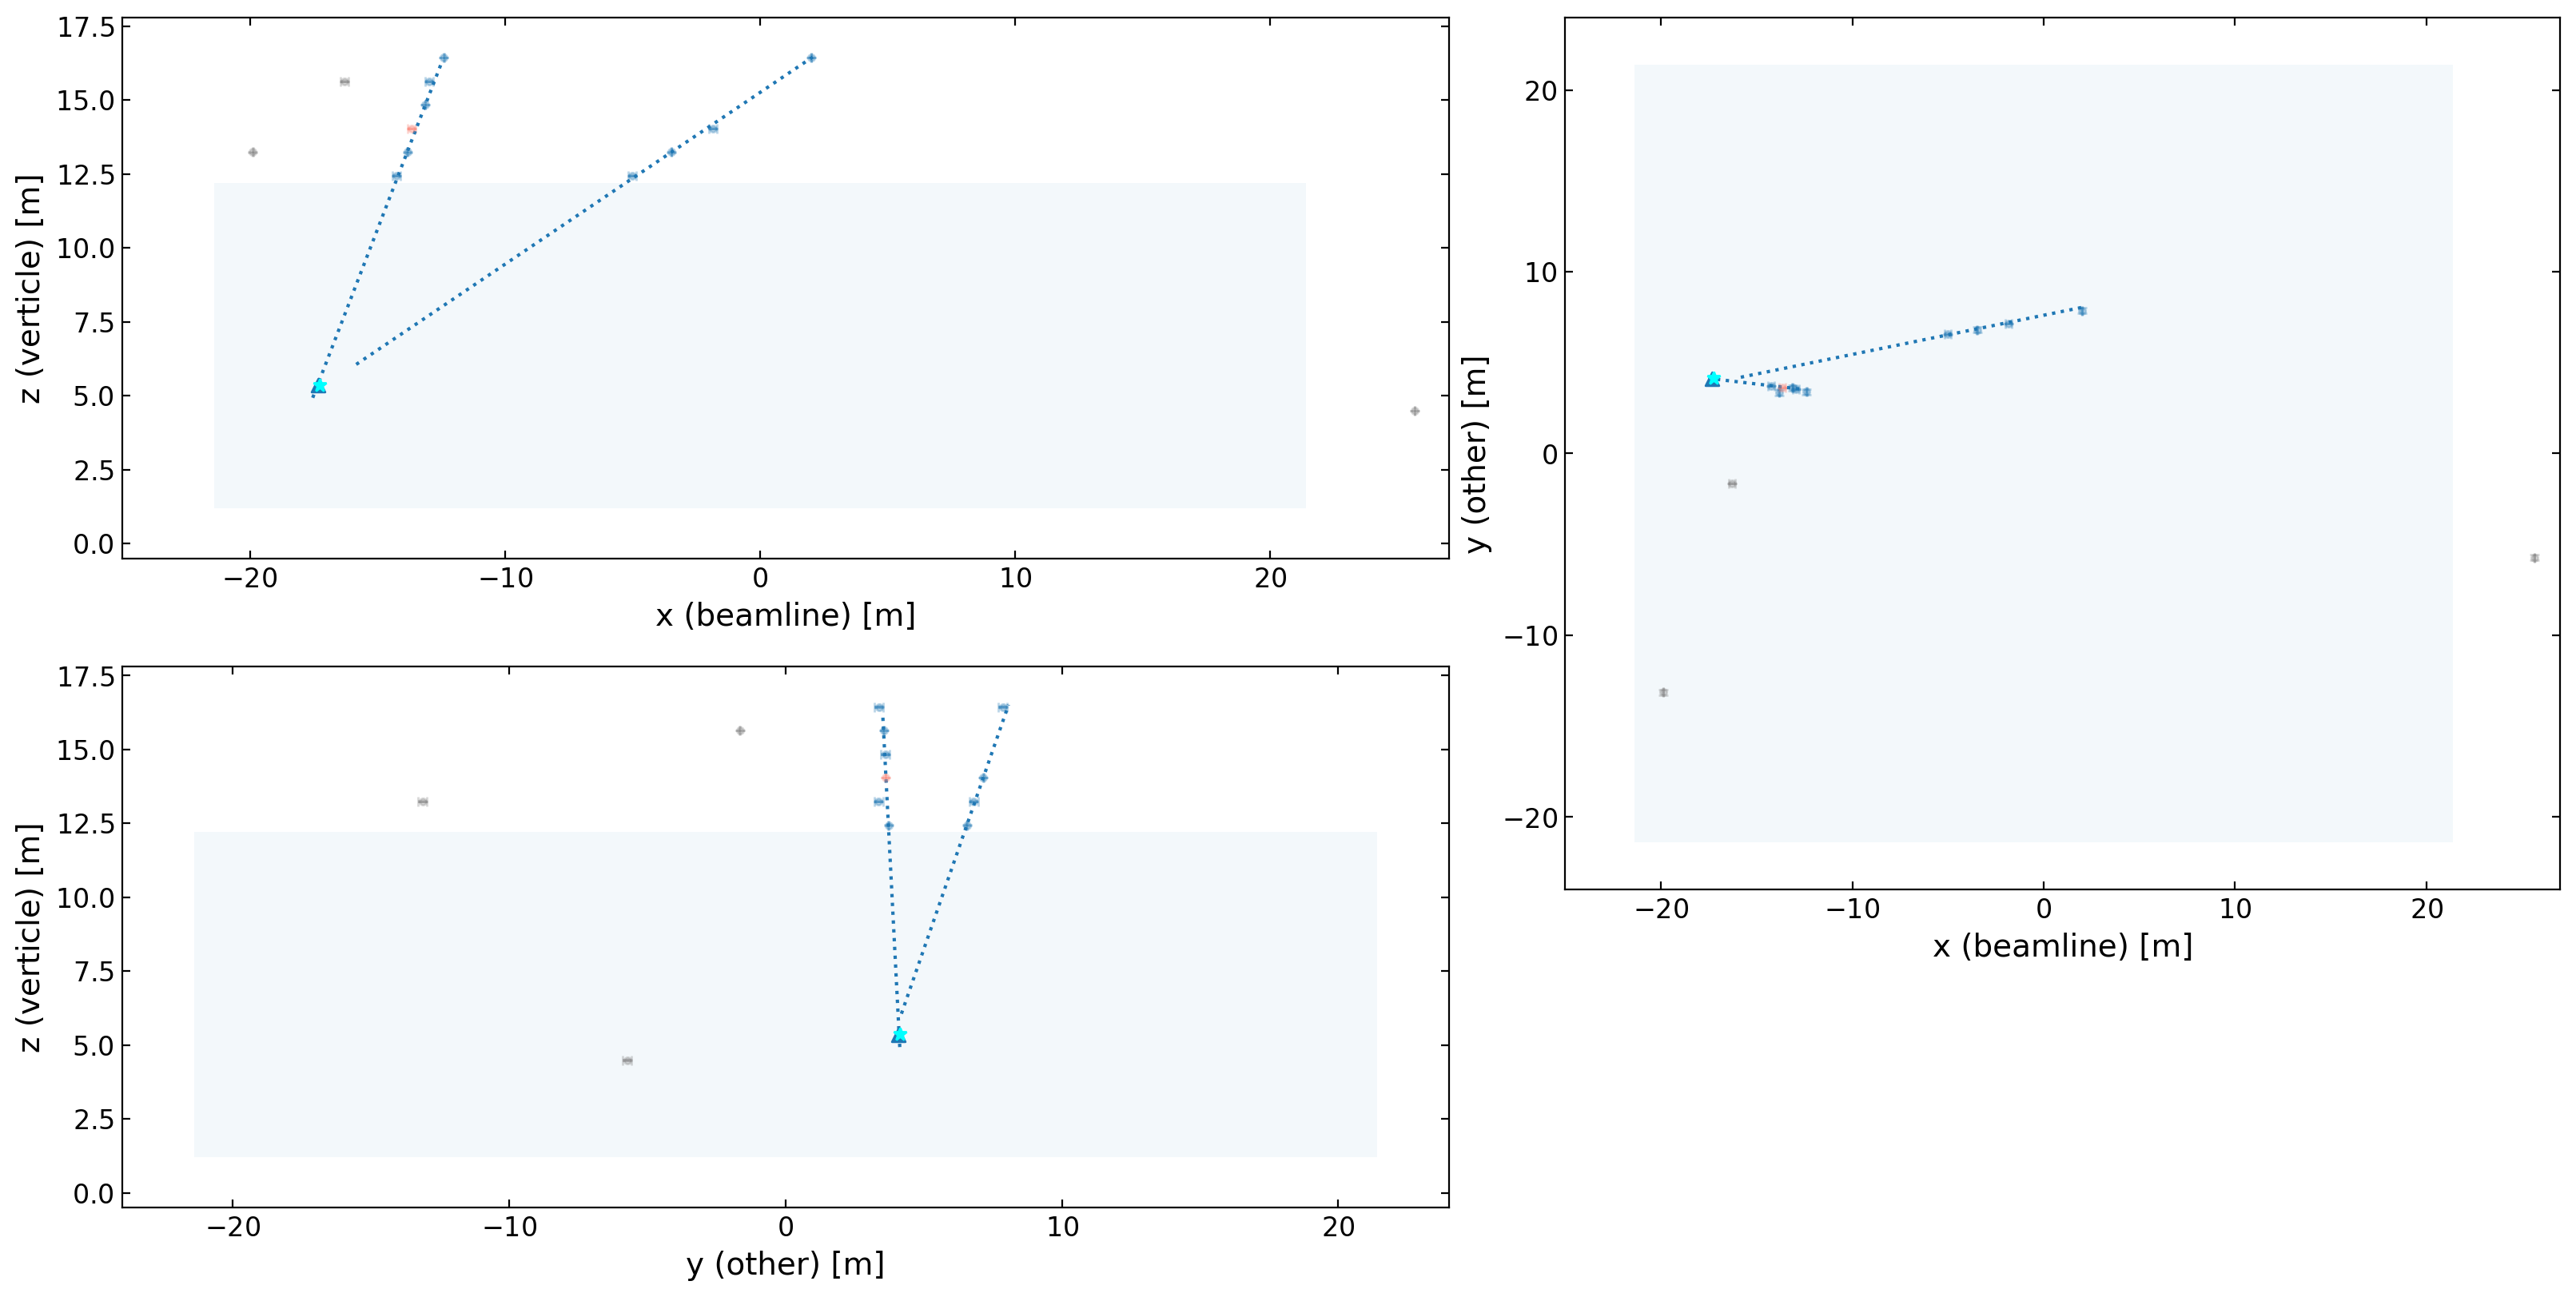

In [788]:
i+=1
# i=0
print(i)

rawdata = fsig1.get_entry(i)
event = datatypes.Event(rawdata, metadata_digi)  
event.plot()


# x = (res["vertex_ndigi_active_after_comp"])[k]
# y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[k]

# print(res["vertex_ntracklet_3+"][rq_inds[i]])
# print(res["vertex_xyzt"][rq_inds[i]])
# print(res["vertex_open_angle"][rq_inds[i]])
# print("consistent, inconsistent", x,y)


In [351]:
fname_comb_p = f"{data_dir}/cedar/cosmic/cosmic_p/merged_p_1200runs.root"
fname_comb_n = f"{data_dir}/cedar/cosmic/cosmic_n/merged_n_2172runs.root"
fname_comb_v = f"{data_dir}/cedar/neutrino/merged.root" # On cedar: /project/6049244/data/MATHUSLA/simulation/run-2024-07-cosmic-neutrino/v2_recon_and_skim/merged.root
fname_comb_mu = f"{data_dir}/cedar/muon/merged.root"# On cedar: /project/6049244/data/MATHUSLA/simulation//run-2024-07-mathusla40-full/v2_recon_and_skim/merged.root

fbkg = root.tfile_reader(fname_comb_p)
fbkg.ls()
## Get metadata
fbkg.get_tree("metadata_digi")
metadata_digi = fbkg.get_entry(0)
fbkg.get_tree("data;1")
print("Entries", fbkg.entries)

fbkg_n = root.tfile_reader(fname_comb_n)
# fbkg_n.ls()
fbkg_n.get_tree("data;1")
print("Entries", fbkg_n.entries)

fbkg_v = root.tfile_reader(fname_comb_v)
# fbkg_n.ls()
fbkg_v.get_tree("data;1")
print("Entries", fbkg_v.entries)

fbkg_mu = root.tfile_reader(fname_comb_mu)
# fbkg_n.ls()
fbkg_mu.get_tree("data;1")
print("Entries", fbkg_mu.entries)

None
Entries 839934
Entries 290908
Entries 30
Entries 24729
TFile**		/home/tomren/geant_projects/musim_test//cedar/cosmic/cosmic_p/merged_p_1200runs.root	
 TFile*		/home/tomren/geant_projects/musim_test//cedar/cosmic/cosmic_p/merged_p_1200runs.root	
  KEY: TTree	metadata;1	Metadata for reconstruction
  KEY: TTree	metadata_digi;1	Metadata for digitization
  KEY: TTree	metadata_recon;1	Simulation metadata
  KEY: TParameter<int>	N_MERGED;1	
  KEY: TTree	data;1	Reconstruction Tree Skimmed


Fiducial volume       566577  200440   23056      22    2835    1225    1756    2976    3600
N digi before          55494   57386      17       0    2706    1163    1647    2811    3375
Track velocity         33213   36904      17       0    2457    1013    1466    2469    2995
Angle to CMS             651     667      13       0    2423     671     560     687     902
Open angle               229     220       0       0     233     506     405     463     592
N track downward         148     197       0       0     225     470     365     404     547
N_hits vs N_veto          50     123       0       0     180     433     338     379     508
N_hits vs N_veto 2        14      22       0       0     122     328     292     341     471

In [360]:
res = data['bkg n']
mask = res.get_cut("Fiducial volume")  & res.get_cut("Track-vertex distance") & res.get_cut("Track-veto distance") &  res.get_cut("Track velocity")  & \
        res.get_cut("N digi before") & res.get_cut("N track downward")  & res.get_cut("N_veto") & res.get_cut("Angle to CMS") & res.get_cut("Open angle") &\
        res.get_cut("N_hits vs N_veto") & res.get_cut("N_hits vs N_veto 2")
rq_inds = np.flatnonzero(mask)
plot_inds = res["ROOT_entry"][mask]

In [361]:
i=0

In [362]:
len(plot_inds)

6

0 22625
4
[18548.104  2746.724  2369.29   -270.471]
0.22718524336282114
consistent, inconsistent 12 9 2


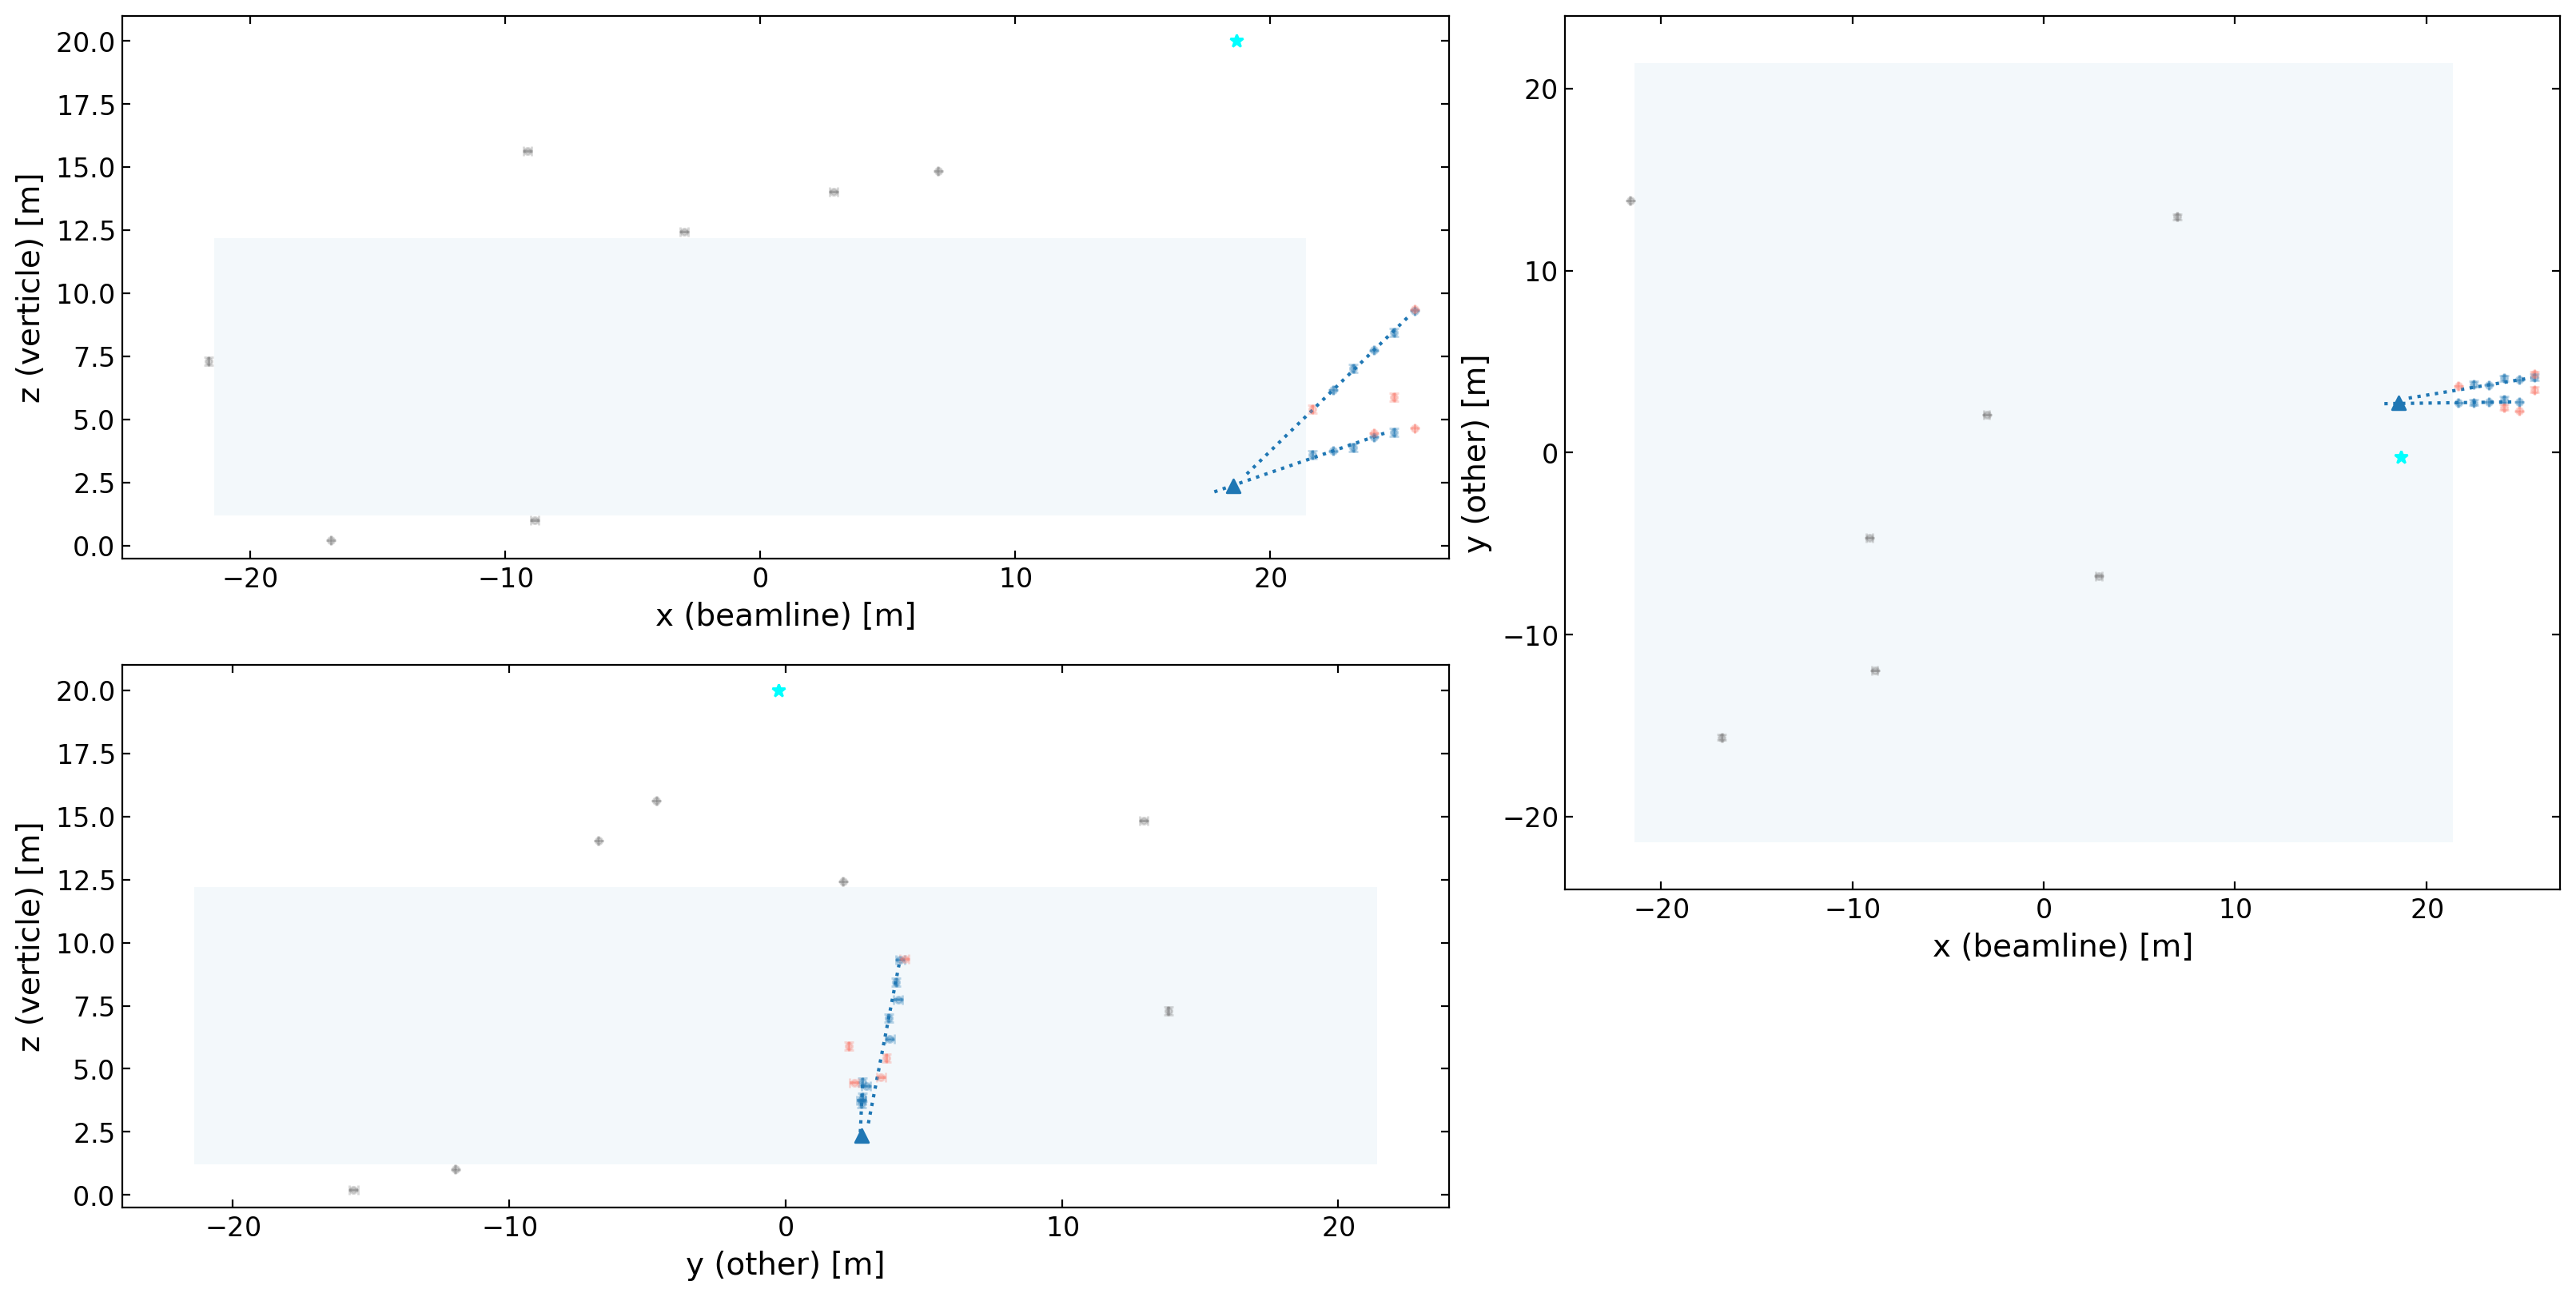

1 69698
2
[-11170.073  14738.793   9998.868   -691.955]
0.1725401061570132
consistent, inconsistent 19 17 5


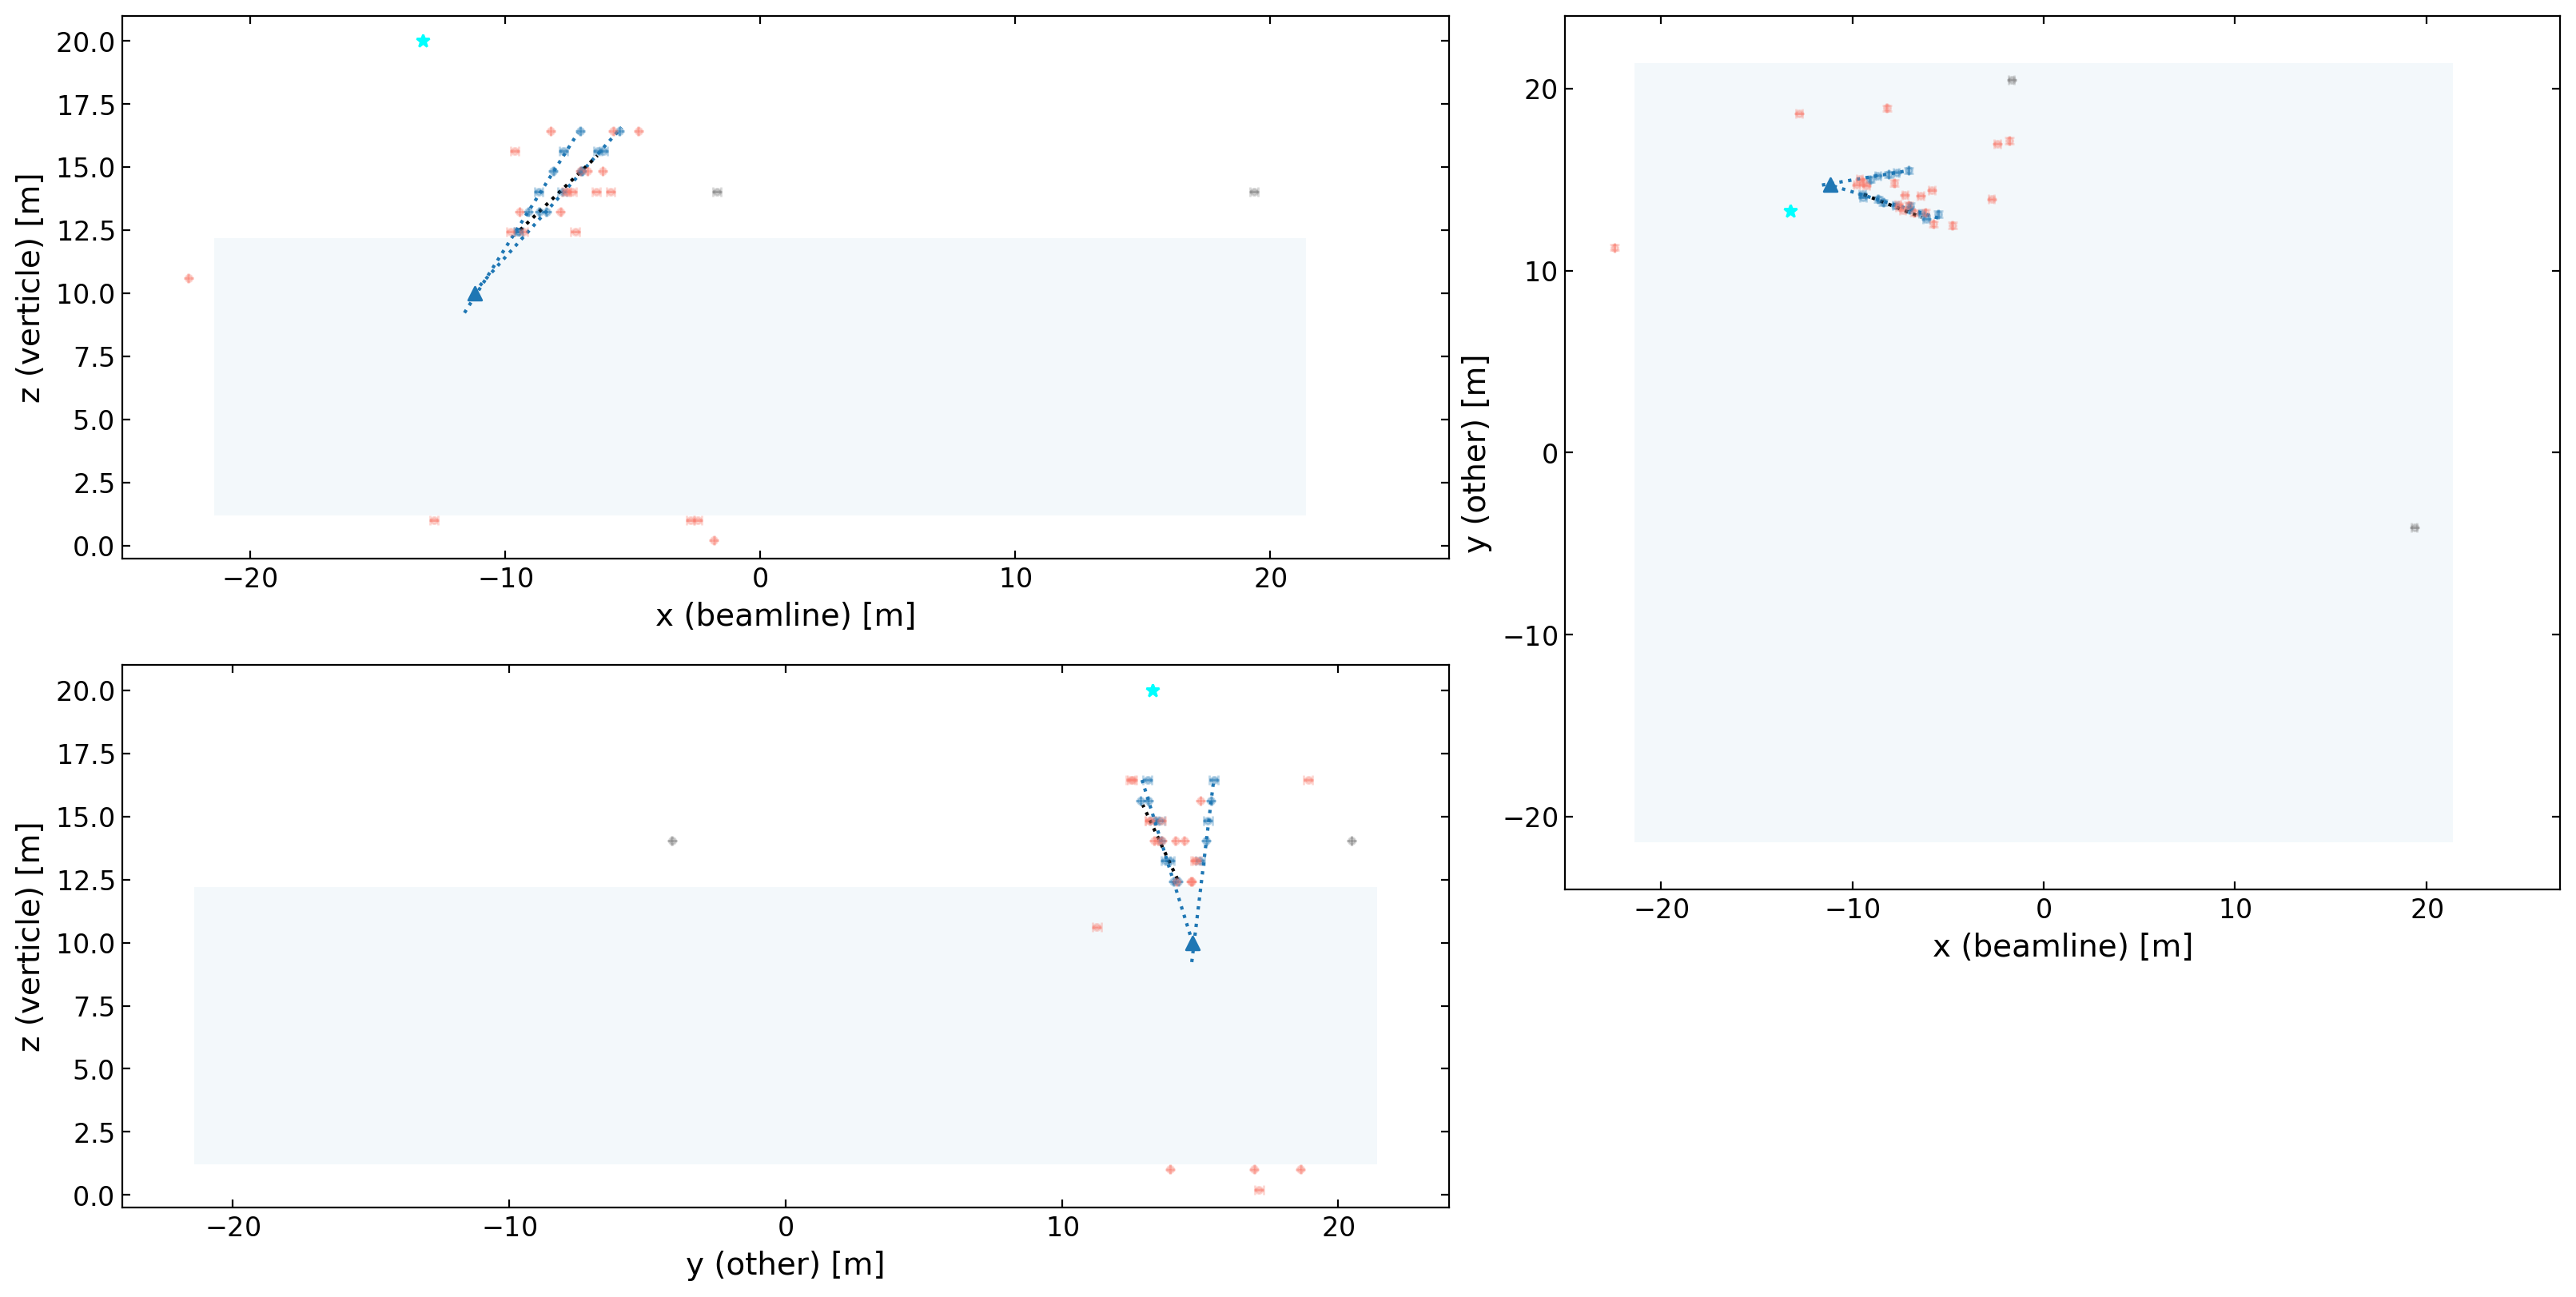

2 87626
4
[17126.963  1260.922  4897.73   -256.127]
0.17060399382792088
consistent, inconsistent 10 14 3


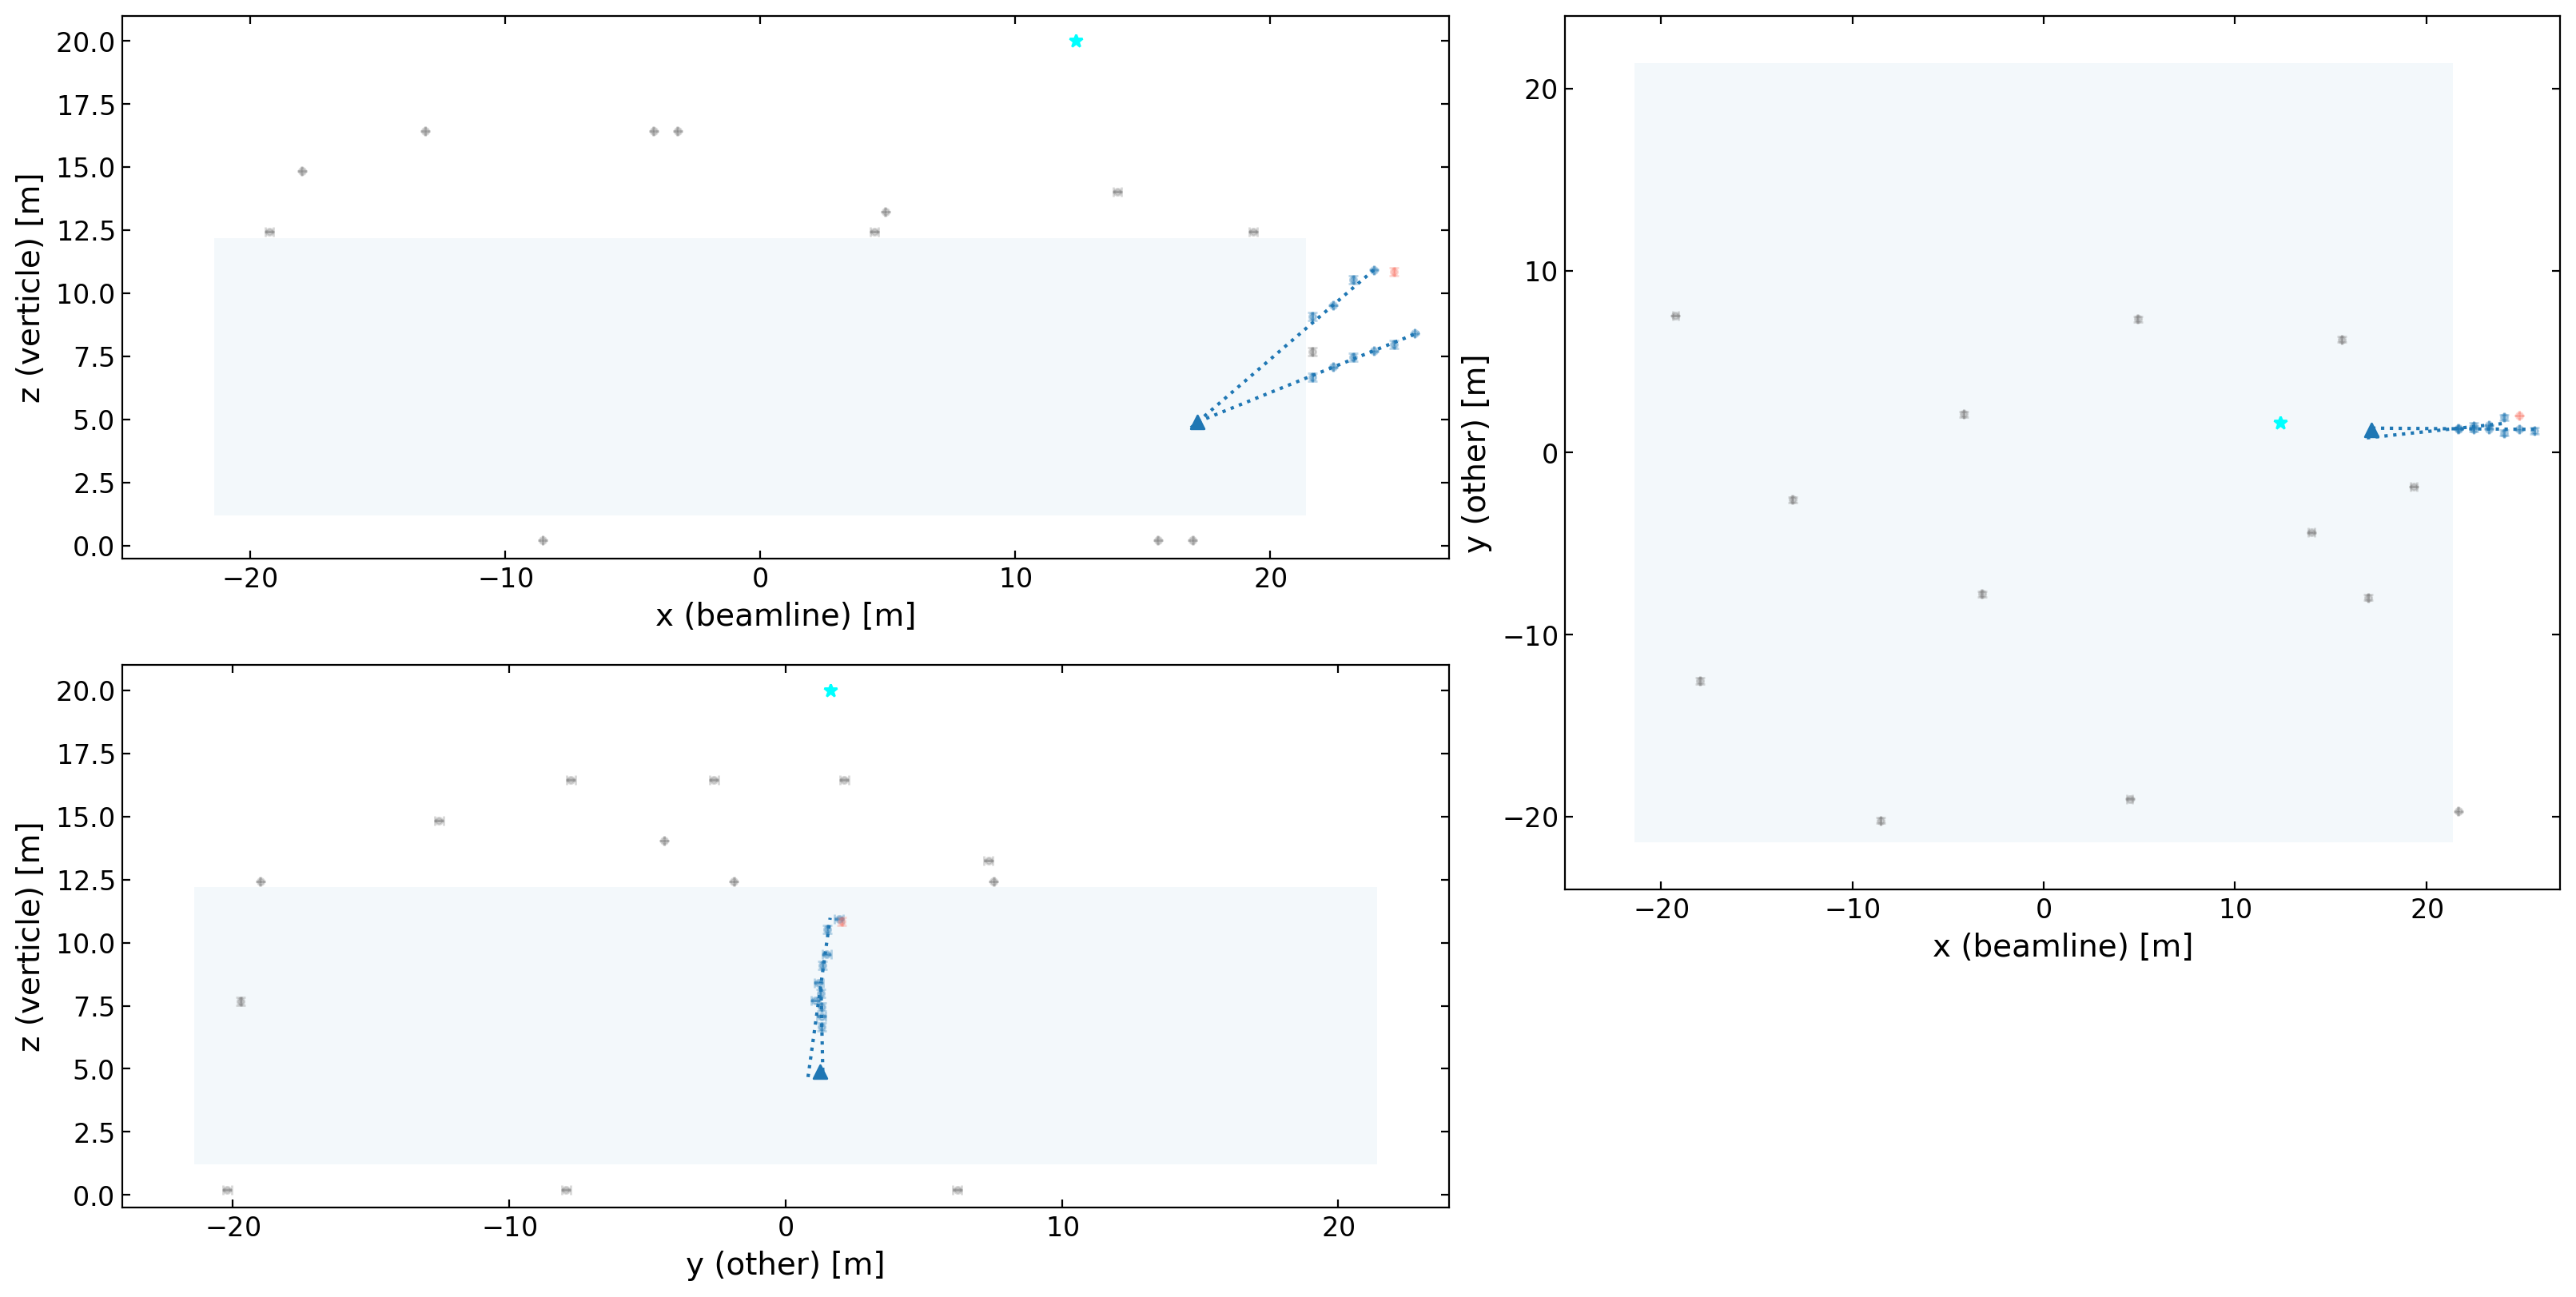

3 103468
2
[11220.326 -1635.583  6319.745  -243.731]
0.48553887211503444
consistent, inconsistent 6 11 0


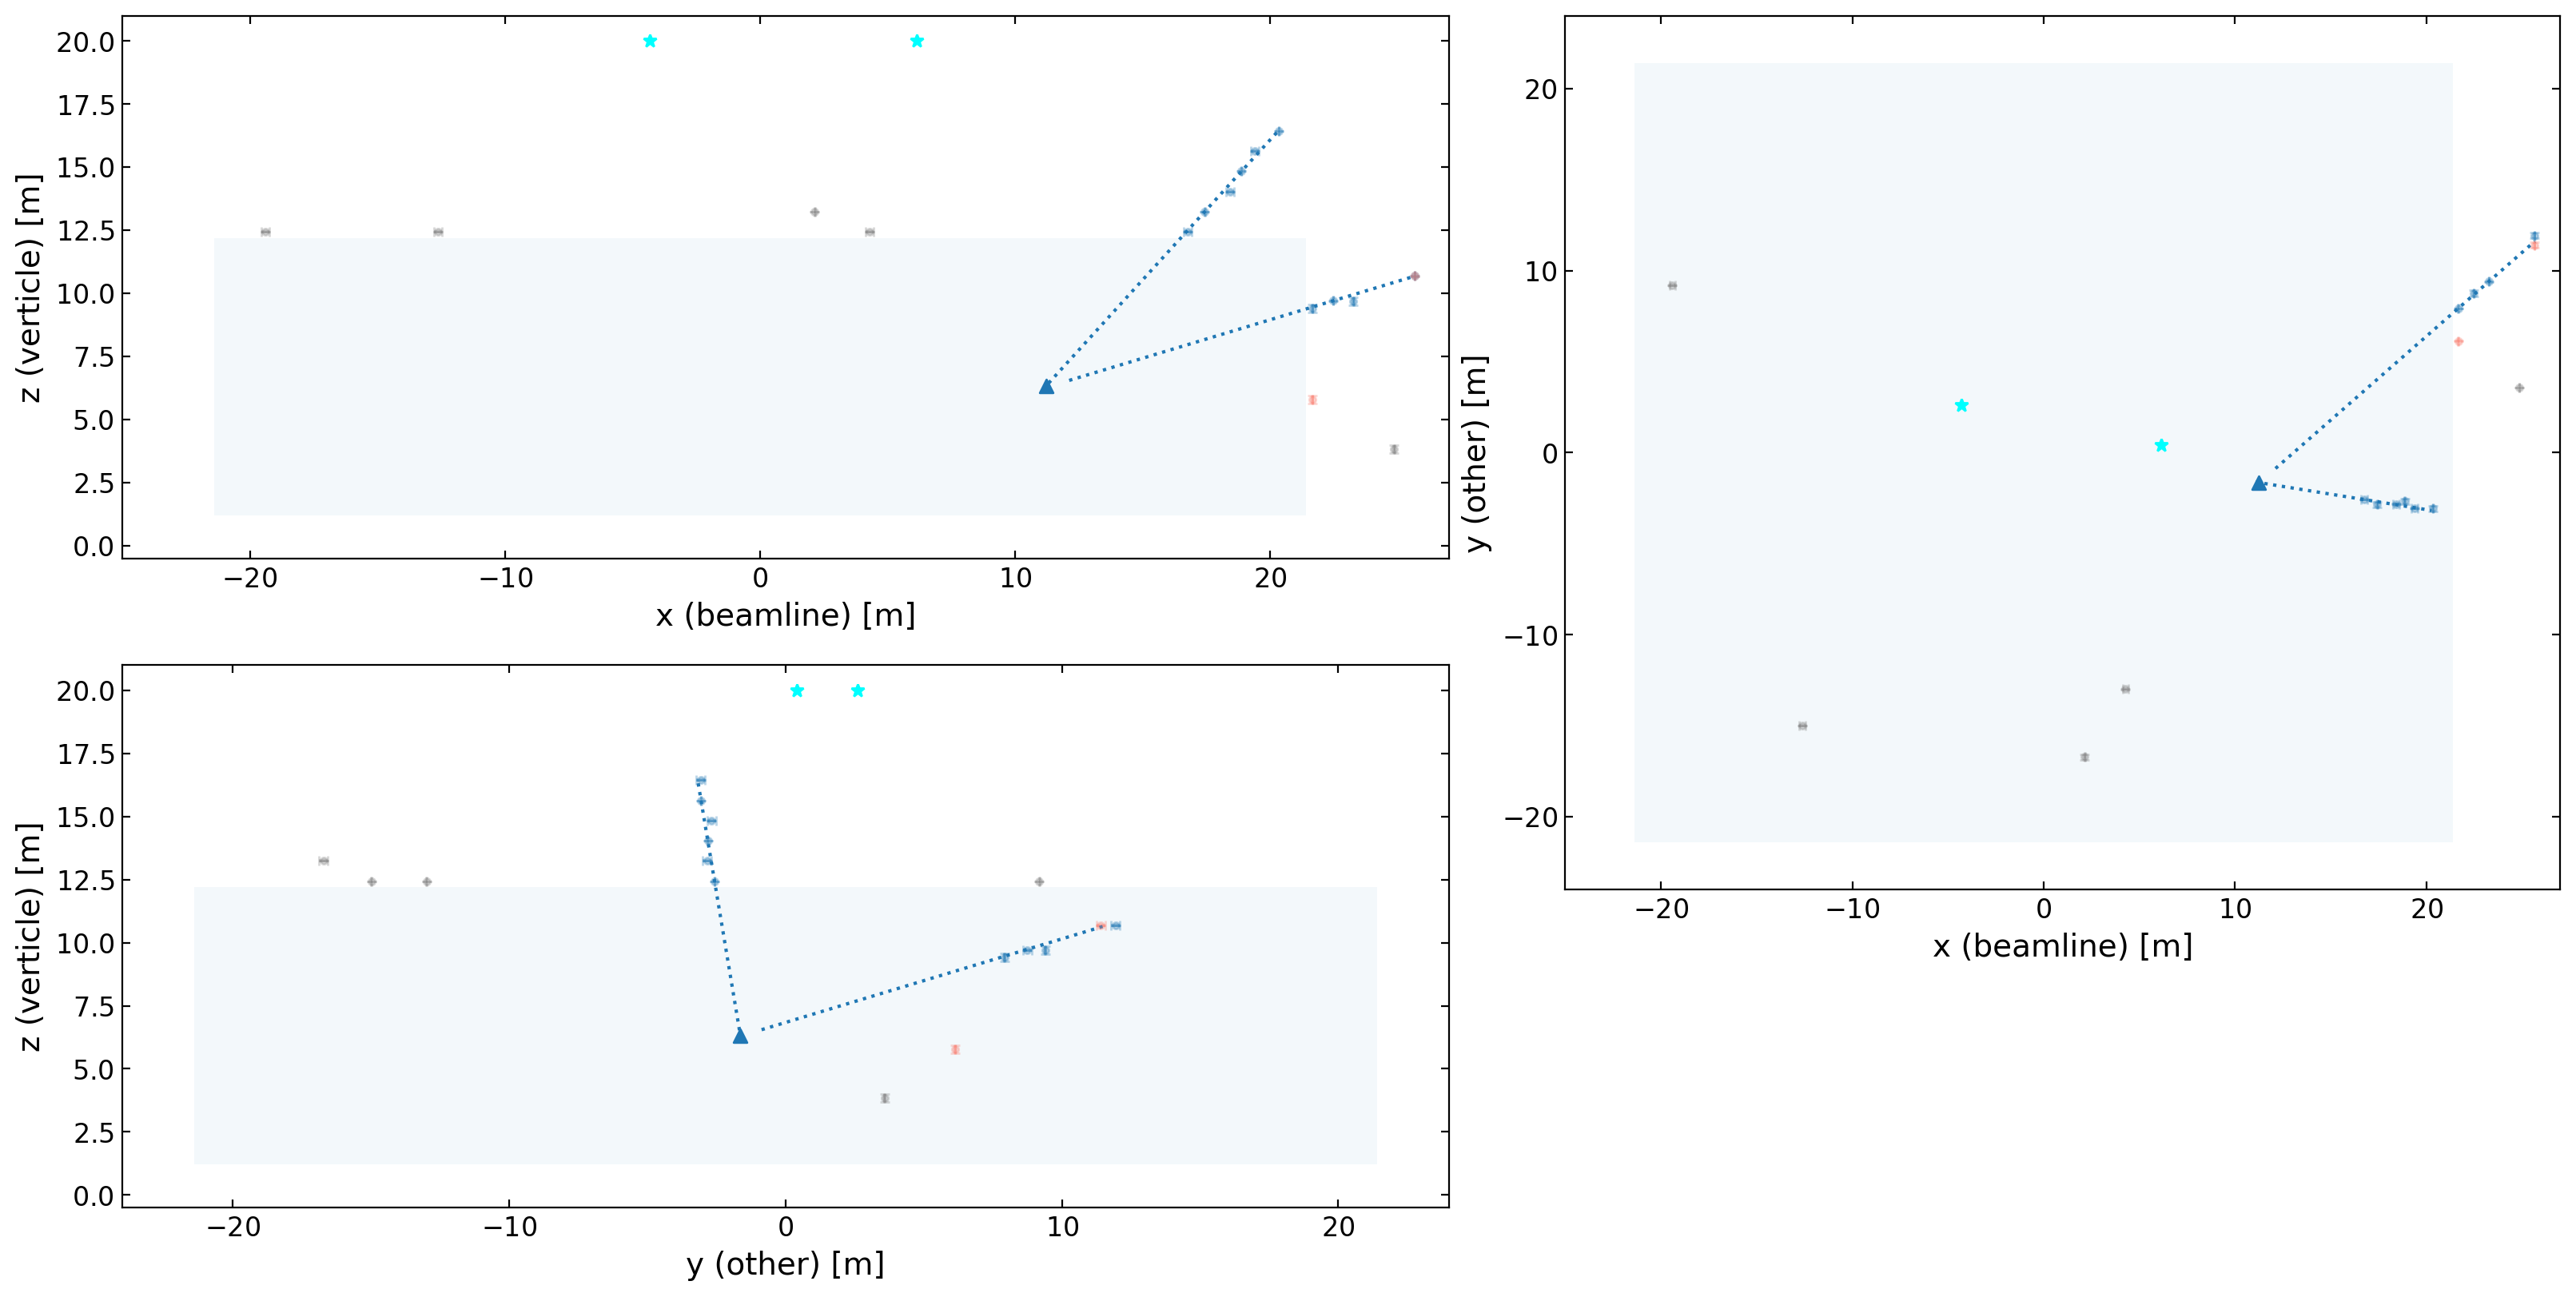

4 155195
3
[14084.354  9547.606  3689.501  -439.866]
0.49026893803997557
consistent, inconsistent 14 6 1


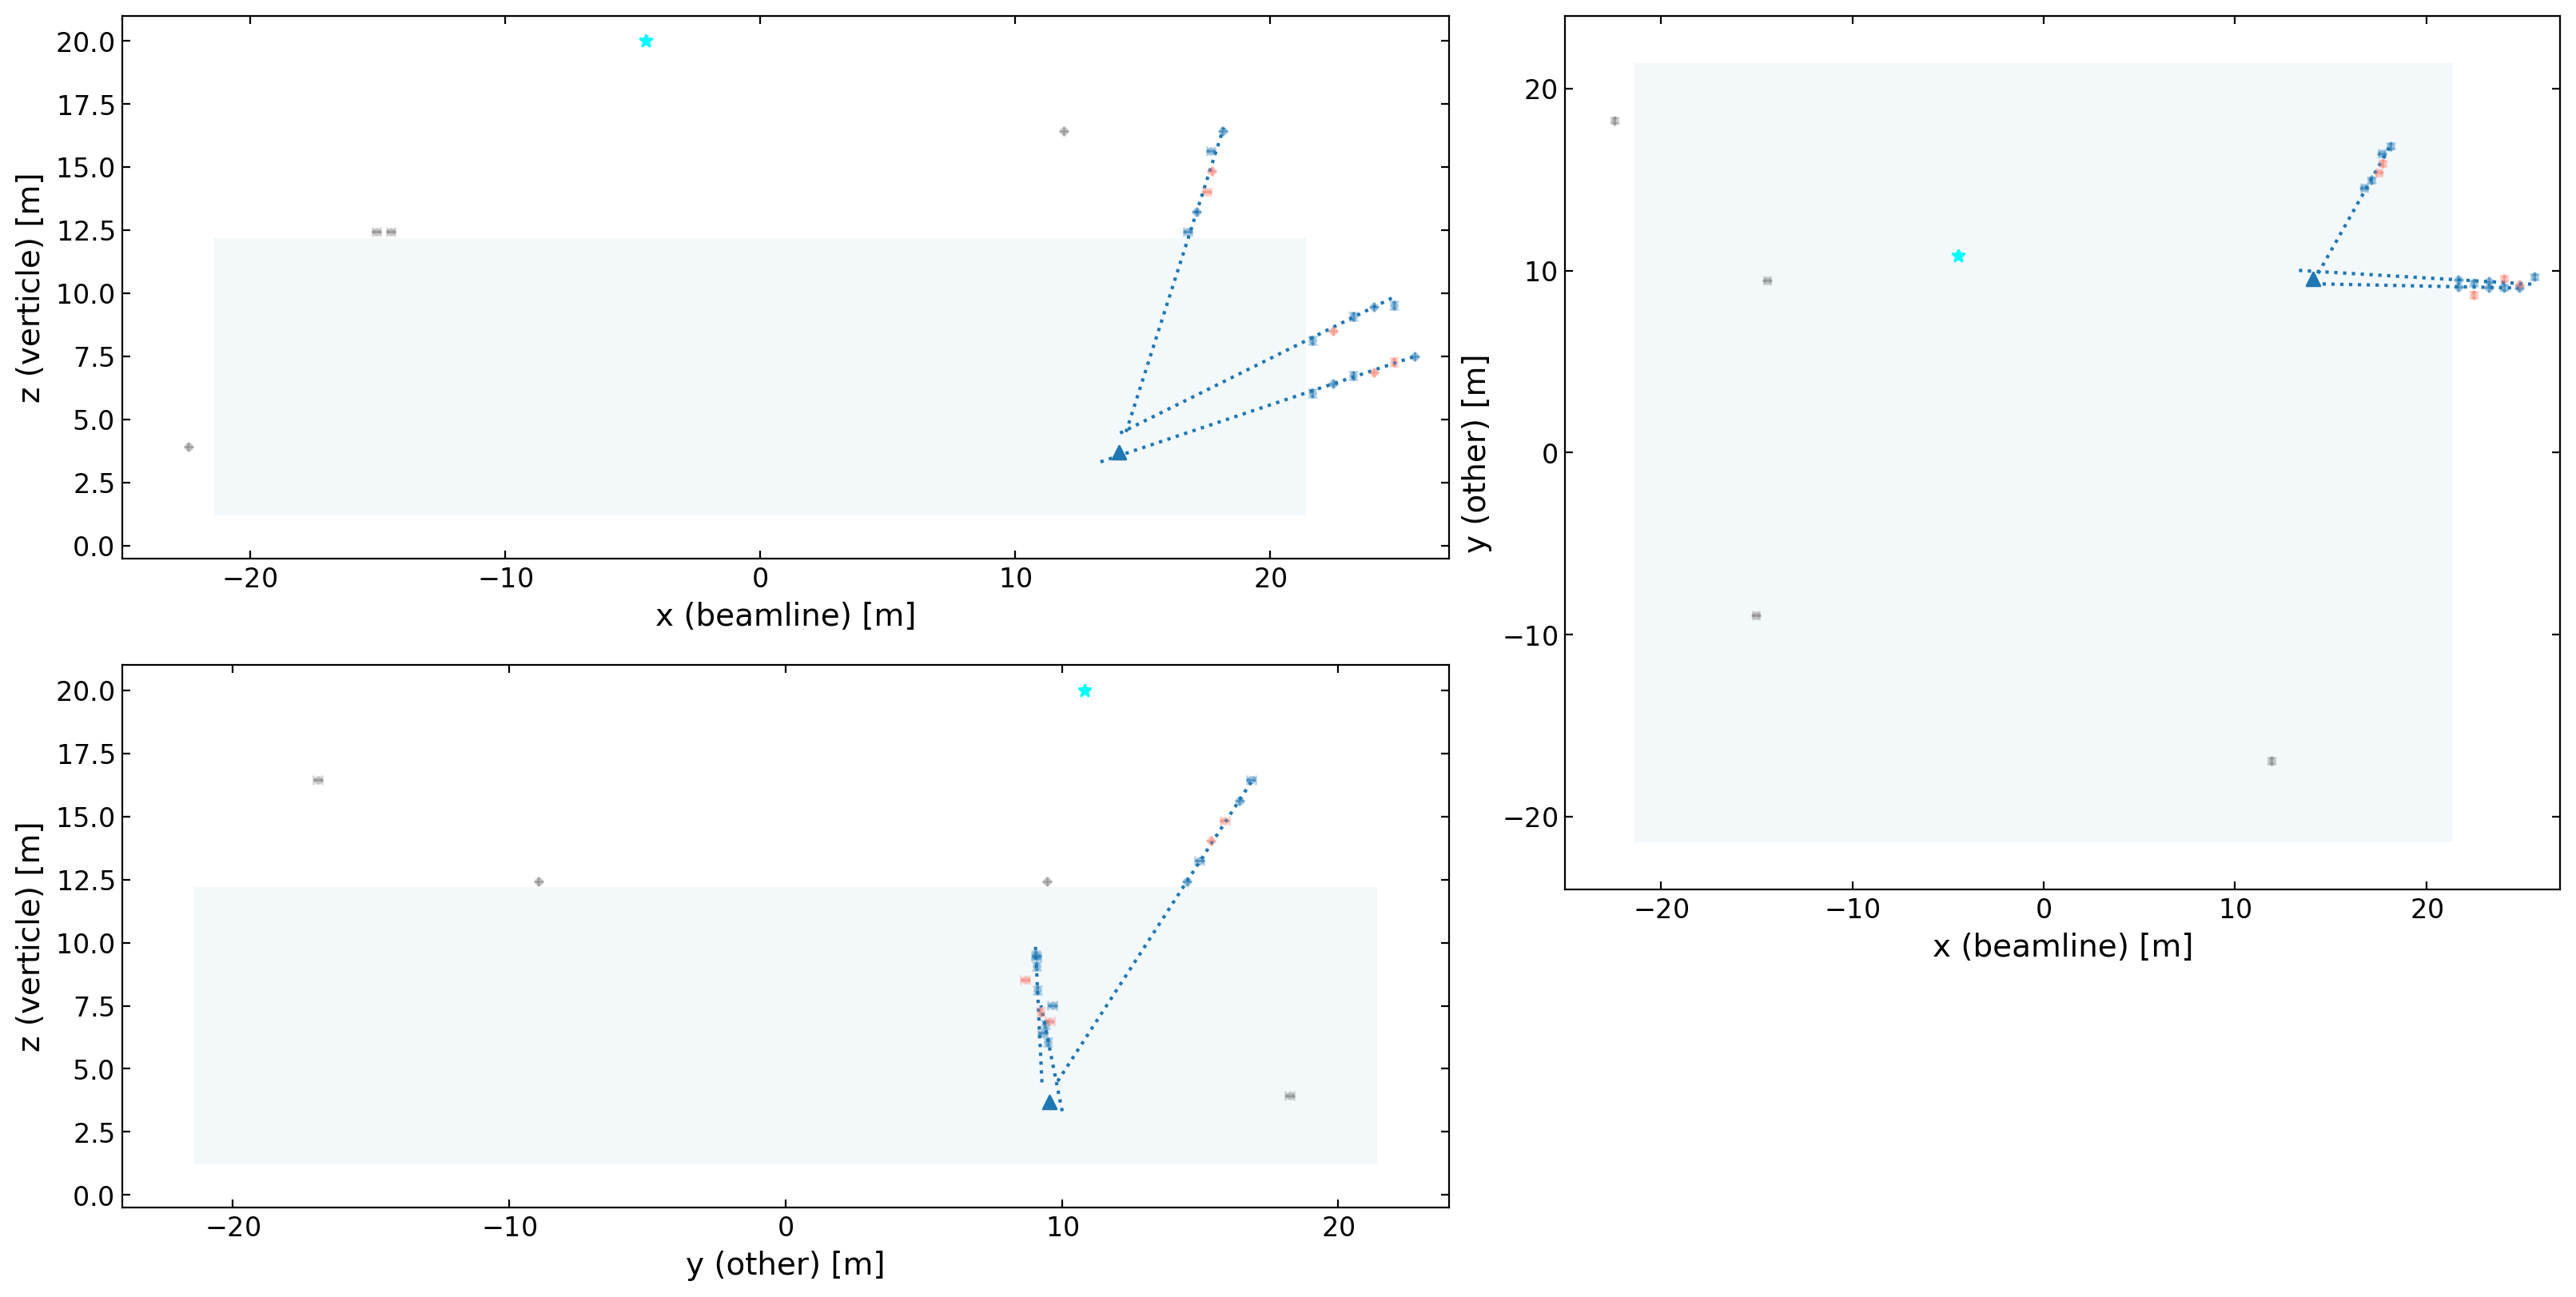

5 240813
1
[-1539.796  4038.249  7679.627  -938.657]
0.47158786769695576
consistent, inconsistent 12 15 3


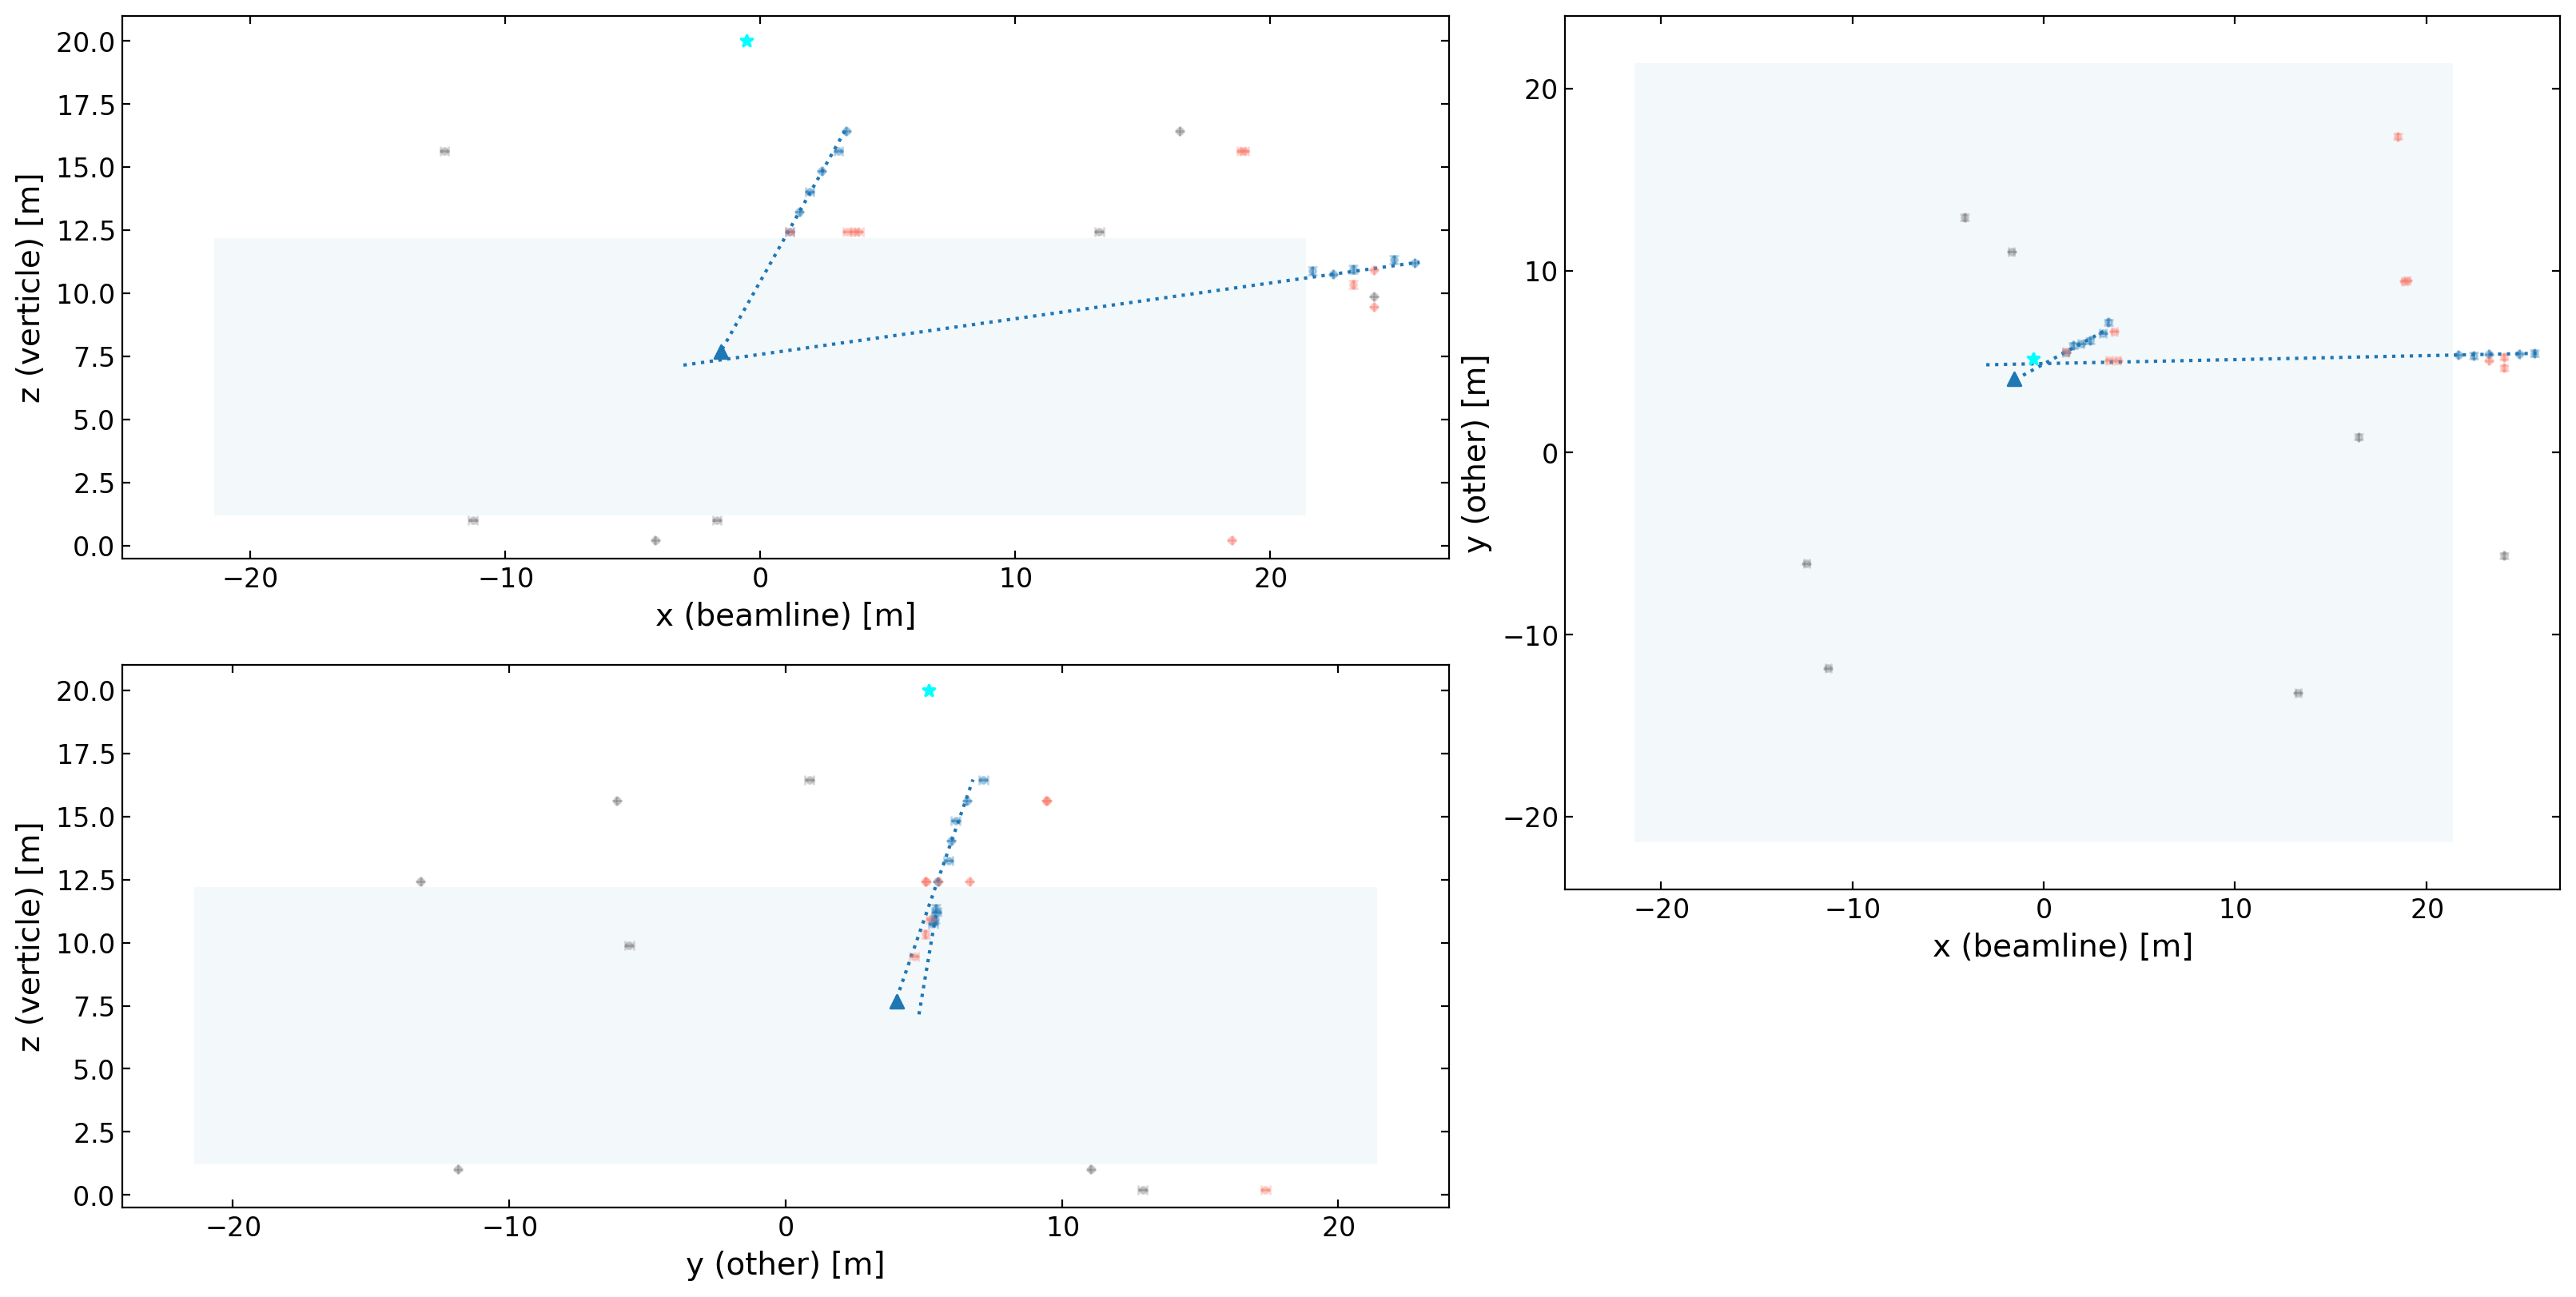

In [363]:
# i=100

for i in range(len(plot_inds)):
# for i in [10]    :
    j=plot_inds[i]
    k = rq_inds[i]
    print(i,j)
    
    x = (res["vertex_ndigi_active_after_comp"])[k]
    y = (res["event_ndigi_veto"] + res["event_ndigi_active"] - res["vertex_ndigi_veto_after_comp"] - res["vertex_ndigi_active_after_comp"])[k]
    
    print(res["vertex_ntracklet_3+"][rq_inds[i]])
    print(res["vertex_xyzt"][rq_inds[i]])
    print(res["vertex_open_angle"][rq_inds[i]])
    print("consistent, inconsistent", x,y, res["event_ndigi_veto"][rq_inds[i]])
    
    rawdata = fbkg_n.get_entry(j)
    event = datatypes.Event(rawdata, metadata_digi, parse_truth=0)  
    event.plot()

    p = [(rawdata["Digi_x"][kk], rawdata["Digi_y"][kk], rawdata["Digi_z"][kk], rawdata["Digi_t"][kk], rawdata["Digi_type"][kk]) for kk in range(len(rawdata["Digi_type"]))]
    # pprint.pp(p)


